# Récapitulatif du notebook précédent

Pour rappel, une chaîne de magasin d'agro-alimentaire, la Poule qui Chante, a décidé de se lancer sur le marché international.

Afin de choisir le pays où installer le nouveau magasin, des analyses exploratoires ainsi que des clusterings ont été demandés.

Dans cette deuxième partie, nous allons effectuer :
 - des clustering
 - des visualisations pour caractériser les clusters 
 - des classifications ascendantes hiérarchiques sous la forme de dendrogramme

# Importation des différentes librairies nécessaires

Nous allons ici importer les librairies utilisées dans le précédent notebook ainsi que de nouvelles pour nous aider à réaliser les analyses et visualisations demandées.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, set_link_color_palette

Grâce à la commande ci-dessous, nous faisons en sorte que toutes les figures générées autrement que par des fonctions créées spécifiquement pour ces analyses auront une même taille standard.

In [2]:
sns.set(rc={'figure.figsize':(20,15)})

# Clustering

Puisque nous avons déjà établi dans la partie précédente que nous allions faire nos analyses en excluant les États-Unis, la Chine, l'Inde et le Brésil, nous d'abord effectuer les clustering avec tous les produits de la dataframe 'dispo' puis un second clustering avec uniquement la volaille comme produit.

## Téléchargement du fichier nécessaire

Nous allons commencer par télécharger le fichier de la jointure des quatres dataframes utilisées pour les analyses précédentes.

In [3]:
acp = pd.read_csv('acp.csv')
acp

,Country,Index,PIB,Population,Export Quantity,Food,Import Quantity,Production
0,Afghanistan,-2.73,516.866552,38972230,884.00,15413.20,5390.10,15029.10
1,Albania,0.08,5332.160475,2866849,188.02,3452.90,849.40,4251.70
2,Algeria,-0.86,3337.252512,43451666,867.59,34199.59,19064.88,30624.88
3,Angola,-0.52,1603.993477,33428485,128.10,19862.68,3188.21,24395.70
4,Antigua and Barbuda,0.93,14787.635775,92664,0.09,56.29,51.32,18.18
...,...,...,...,...,...,...,...,...
170,Uzbekistan,-0.44,1749.655815,33526656,3135.24,33323.93,5459.93,39981.72
171,Vanuatu,0.90,2877.520173,311685,90.48,191.89,51.10,506.79
172,Zambia,-0.13,956.831364,18927715,611.10,8762.15,521.83,16261.94
173,Zimbabwe,-1.08,1372.696674,15669666,307.54,4636.07,1790.15,8616.23


## Séparation des données

Cette partie ainsi que les deux suivantes sont décrites dans le premier notebook.

Il n'est donc pas nécessaire de réexpliquer ces parties.

In [4]:
acp = acp.set_index('Country')
acp = acp[(acp.index != 'China, mainland')&(acp.index != 'India')&(acp.index != 'Brazil')&(acp.index != 'United States of America')]
acp

,Index,PIB,Population,Export Quantity,Food,Import Quantity,Production
Country,,,,,,,
Afghanistan,-2.73,516.866552,38972230,884.00,15413.20,5390.10,15029.10
Albania,0.08,5332.160475,2866849,188.02,3452.90,849.40,4251.70
Algeria,-0.86,3337.252512,43451666,867.59,34199.59,19064.88,30624.88
Angola,-0.52,1603.993477,33428485,128.10,19862.68,3188.21,24395.70
Antigua and Barbuda,0.93,14787.635775,92664,0.09,56.29,51.32,18.18
...,...,...,...,...,...,...,...
Uruguay,1.05,15619.542656,3429086,6178.33,2624.74,1012.17,10080.94
Uzbekistan,-0.44,1749.655815,33526656,3135.24,33323.93,5459.93,39981.72
Vanuatu,0.90,2877.520173,311685,90.48,191.89,51.10,506.79


In [5]:
X = acp.values
names = acp.index
features = acp.columns

## Centrer-Réduire

In [6]:
scaler = StandardScaler()

In [7]:
X_scaled = scaler.fit_transform(X)

In [8]:
idx = ["mean", "std"]

pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

,0,1,2,3,4,5,6
mean,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## Analyse en Composantes Principales

Pour nous aider dans nos visualisations, nous avons besoin de réinitialiser une ACP.

In [9]:
n_components = 6
pca = PCA(n_components=n_components)
pca.fit(X_scaled)

PCA(n_components=6)

## Méthode des Kmeans

Cette méthode permet de créer nos clusters, la seule condition est de renseigner le nombre de clusters que nous souhaitons créer.

Pour cela, nous utiliserons la méthode du coude qui consiste à repérer une 'cassure' sur un graphique qui représente l'inertie par rapport aux nombres de clusters.

Cette cassure nous renseignera sur le nombre optimal de clusters à créer via la méthode des Kmeans.

In [10]:
# Une liste vide pour enregistrer les inerties :  
intertia_list = [ ]

# Notre liste de nombres de clusters : 
k_list = range(1, 10)

# Pour chaque nombre de clusters : 
for k in k_list : 
    
    # On instancie un k-means pour k clusters
    kmeans = KMeans(n_clusters=k)
    
    # On entraine
    kmeans.fit(X)
    
    # On enregistre l'inertie obtenue : 
    intertia_list.append(kmeans.inertia_)

C:\Users\Elenweii\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


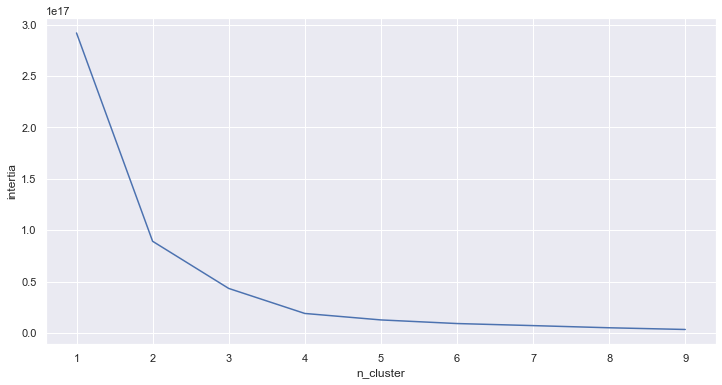

In [11]:
fig, ax = plt.subplots(1,1,figsize=(12,6))

ax.set_ylabel("intertia")
ax.set_xlabel("n_cluster")
plt.savefig('coude_kmeans.png')
ax = plt.plot(k_list, intertia_list)

Sur ce graphique, nous pouvons clairement voir trois cassures : une pour 2 clusters, une autre pour 3 et une dernière pour 4.

La solution la plus simple, et donc celle que nous utiliserons, sera de prendre la dernière cassure nette du graphique.

Donc nous créerons 4 clusters.

## Projections sur un plan factoriel des clusters avec leur centroïdes

Nous commençons par créer une fonction qui permettra la projection à la fois des individus sur un plan factoriel, mais également les centroïdes des clusters générés par la méthode des kmeans.

In [12]:
def display_with_centroids(   X_projected, 
                              centroids_projected,
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[10,8], 
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    #Change le nom de centroids_projected
    cen_ = centroids_projected
    
    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha, 
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, alpha=0.4, palette ='deep')
    
    #Les centroides
    sns.scatterplot(data=None, x=cen_.iloc[:,x], y=cen_.iloc[:,y], marker= 'x',hue=cen_.index , legend=False,s = 100,
                    palette='deep')

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}',fontsize=15)
    ax.set_ylabel(f'F{y+1} {v2}',fontsize=15)

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center')        

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})", fontsize=20)
    plt.savefig(f'proj_cent_F{x+1}_F{y+1}.png')
    plt.show()

Miantenant nous allons dès à present extraire les coordonnées des individus.

In [13]:
X_proj = pca.transform(X_scaled)

Nous initions maintenant la méthode des Kmeans en renseignant le nombre de clusters souhaités, à savoir 4.

In [14]:
kmeans = KMeans(n_clusters=4,random_state=42)
kmeans.fit(X)

KMeans(n_clusters=4, random_state=42)

Nous réinitialisons X en rajoutant une colonne pour indiquer dans quel cluster se trouvent les pays.

In [15]:
X = acp.copy()
labels = kmeans.labels_
X["cluster"] = labels
X

,Index,PIB,Population,Export Quantity,Food,Import Quantity,Production,cluster
Country,,,,,,,,
Afghanistan,-2.73,516.866552,38972230,884.00,15413.20,5390.10,15029.10,2
Albania,0.08,5332.160475,2866849,188.02,3452.90,849.40,4251.70,0
Algeria,-0.86,3337.252512,43451666,867.59,34199.59,19064.88,30624.88,2
Angola,-0.52,1603.993477,33428485,128.10,19862.68,3188.21,24395.70,2
Antigua and Barbuda,0.93,14787.635775,92664,0.09,56.29,51.32,18.18,0
...,...,...,...,...,...,...,...,...
Uruguay,1.05,15619.542656,3429086,6178.33,2624.74,1012.17,10080.94,0
Uzbekistan,-0.44,1749.655815,33526656,3135.24,33323.93,5459.93,39981.72,2
Vanuatu,0.90,2877.520173,311685,90.48,191.89,51.10,506.79,0


Nous initialisons maintenant les centroïdes de nos clusters.

In [16]:
centroids = kmeans.cluster_centers_
centroids_scaled = scaler.transform(centroids)
centroids_proj = pca.transform(centroids_scaled)
centroids_proj = pd.DataFrame(centroids_proj)

Nous pouvons maintenant passer aux projections sur F1, F2 et F3.

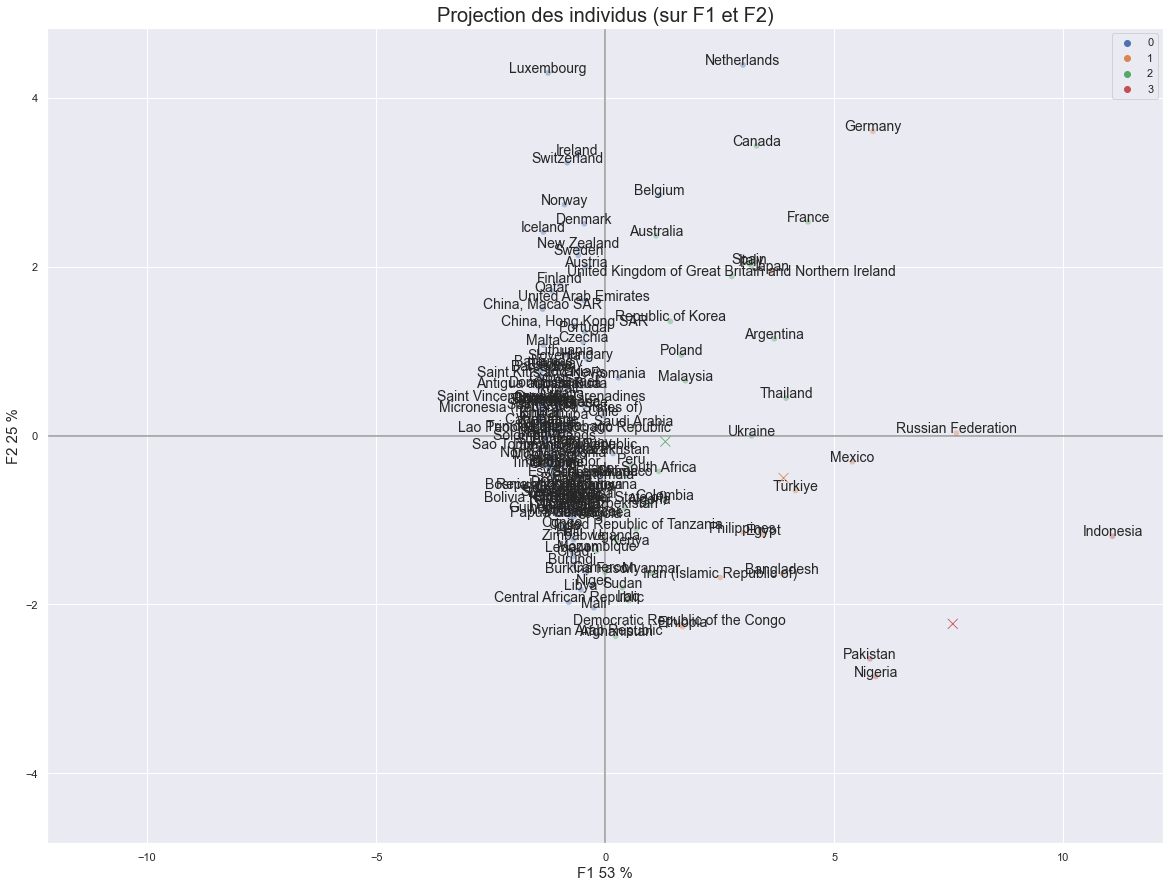

In [17]:
display_with_centroids(X_proj,centroids_proj, (0,1), pca, labels = names, clusters=labels, figsize=(20,15), marker="o")

Ci-dessus, nous avons une projection des individus ainsi que des centroïdes cependant les noms rendant impossible l'identification des clusters et des centroïdes, nous allons refaire le graphique en supprimant les noms.

Ici, nous repérons la France proche de la Grande-Bretagne, de l'Espagne, du Japon et peut-être de l'Italie.

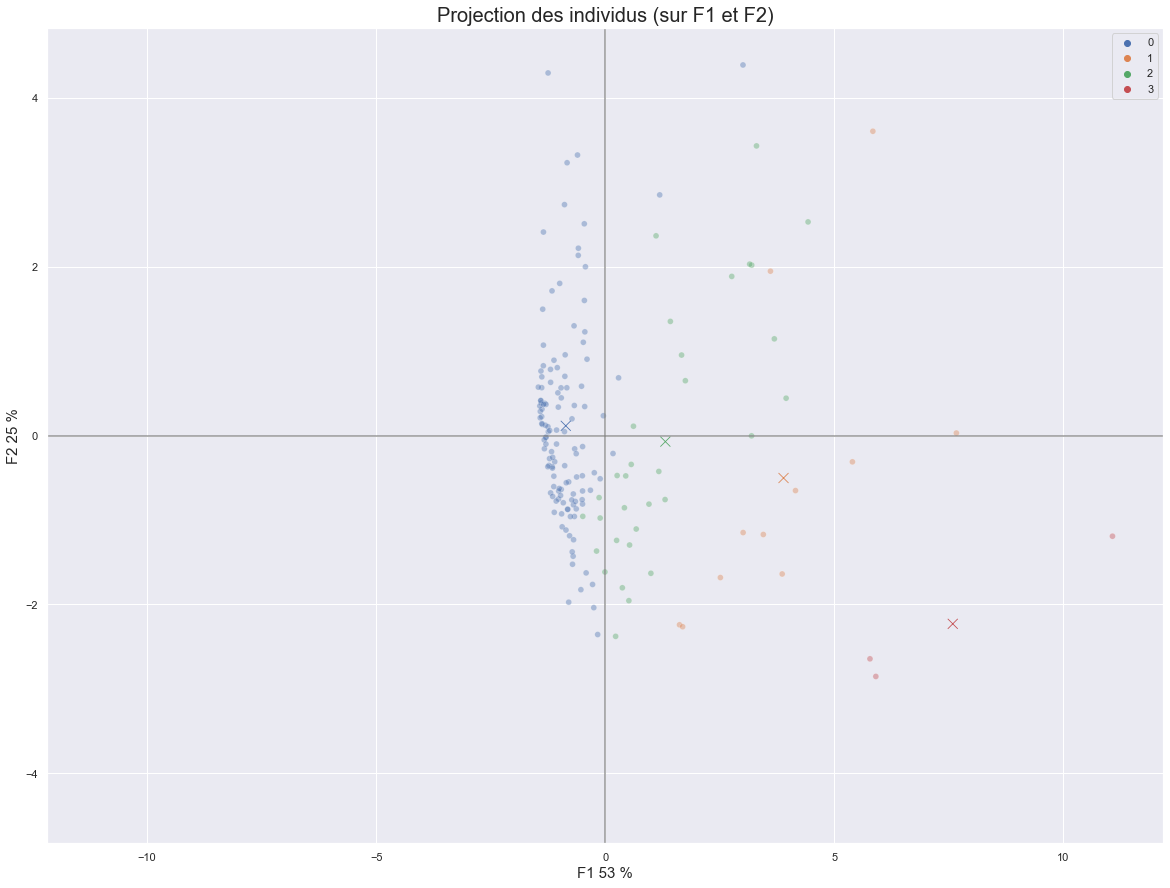

In [18]:
display_with_centroids(X_proj,centroids_proj, (0,1), pca, clusters=labels, figsize=(20,15), marker="o")

De gauche à droite, nous avons :
 - le premier centroïde représente un individu moyen avec un PIB par habitant et un index de stabilité politique moyen tandis que sa population, sa production et sa nourriture sont un peu plus faible que la moyenne.
 
 
 - le second centroïde représente un individu avec un PIB et un index assez similaire au premier mais sa population, sa production et sa nourriture sont un peu plus important que la moyenne.
 
 
 - le troisième centroïde représente un individu avec un PIB et un index plus faible que la moyenne, en revanche sa nourriture, sa production et sa population sont importantes.
 
 
 - le dernier centroïde représente un individu avec un PIB et un index très faible, quant à sa population, sa production et sa nourriture, elles sont très importantes.

Ici, la France est dans le cluster du second centroïde.

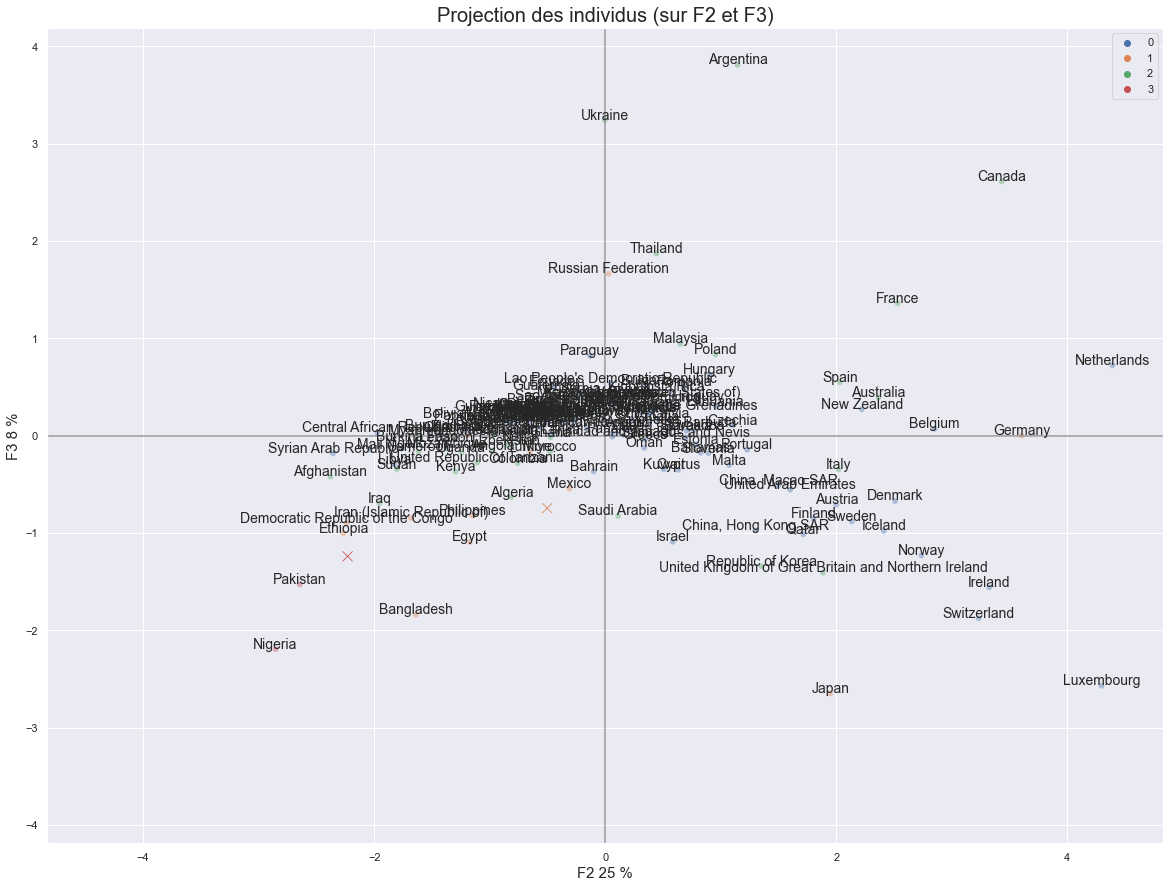

In [19]:
display_with_centroids(X_proj,centroids_proj, (1,2), pca, labels = names, clusters=labels, figsize=(20,15), marker="o")

Nous pouvons trouver la France proche de l'Espagne et de l'Australie.

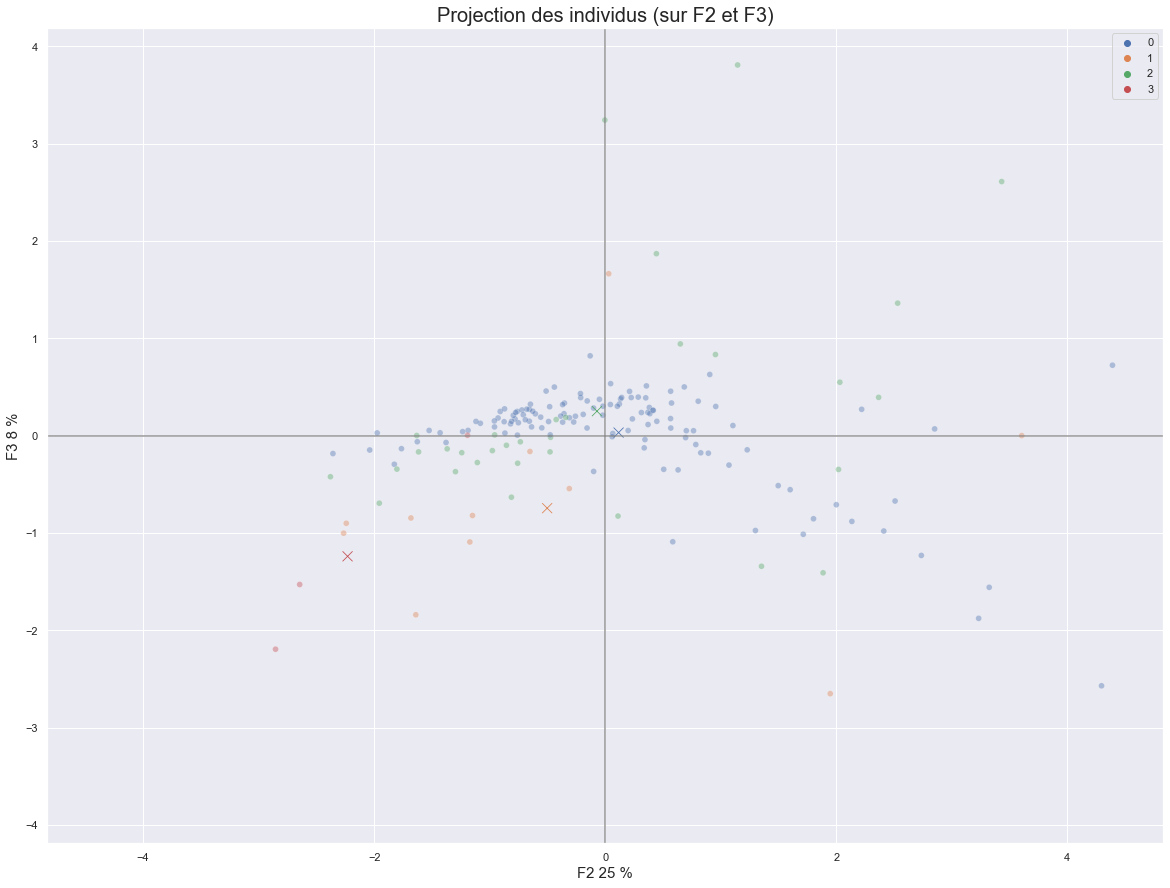

In [20]:
display_with_centroids(X_proj,centroids_proj, (1,2), pca, clusters=labels, figsize=(20,15), marker="o")

De gauche à droite, nous avons :
 - le premier centroïde traduit un individu ayant de faibles exportations
 
 - le second centroïde a des exportations un peu plus importantes que le premier mais toujours plus faibles que la moyenne
 
 - les troisième et quatrième centroïdes un des exportations moyennes 

## Caractérisation des clusters via des boxplots des différentes variables

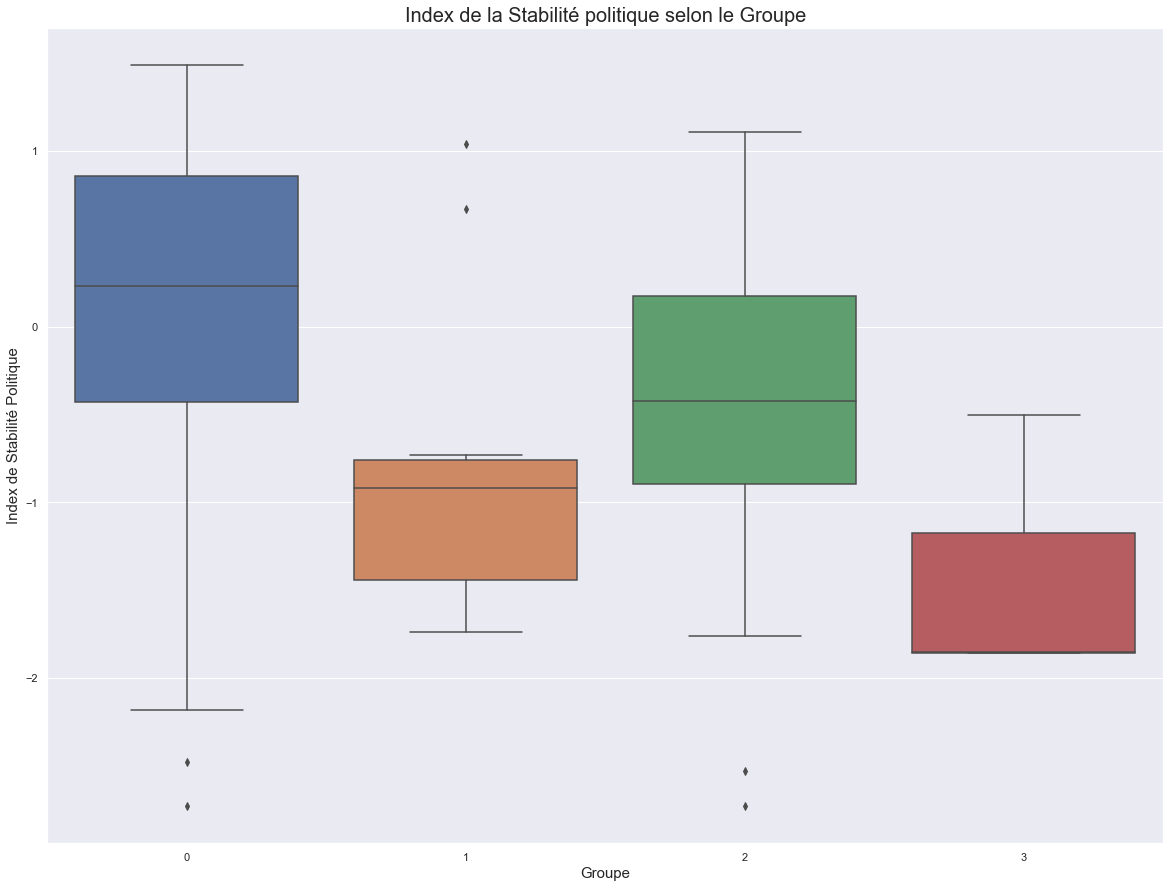

In [21]:
sns.boxplot(data = X, x= 'cluster', y='Index')
plt.xlabel('Groupe',fontsize =15)
plt.ylabel('Index de Stabilité Politique',fontsize=15)
plt.title('Index de la Stabilité politique selon le Groupe', fontsize=20)
plt.savefig('index.png')

Cluster 0 : index en général positif ou proche de 0

Cluster 1 : index négatif proche de -1

Cluster 2 : index en général négatif avec une médiane de -0.5

Cluster 3 : index négatif avec une médiane proche de -2

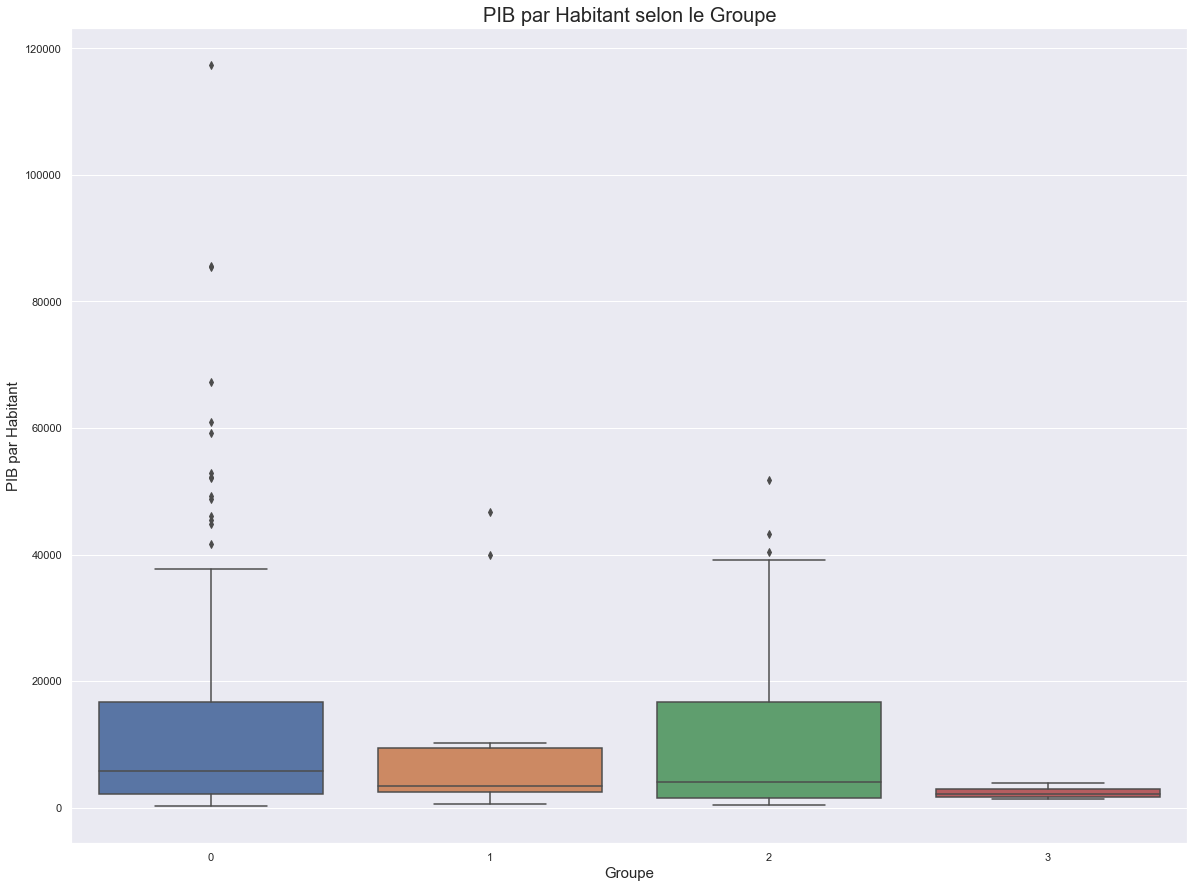

In [22]:
sns.boxplot(data = X, x= 'cluster', y='PIB')
plt.xlabel('Groupe',fontsize =15)
plt.ylabel('PIB par Habitant',fontsize=15)
plt.title('PIB par Habitant selon le Groupe', fontsize=20)
plt.savefig('pib.png')

Cluster 0 : Possède les PIB les plus importants

Cluster 1 : PIB plus faible que pour le cluster 0 avec deux exceptions

Cluster 2 : Cluster assez similaire au cluster 0

Cluster 3 : PIB très faible

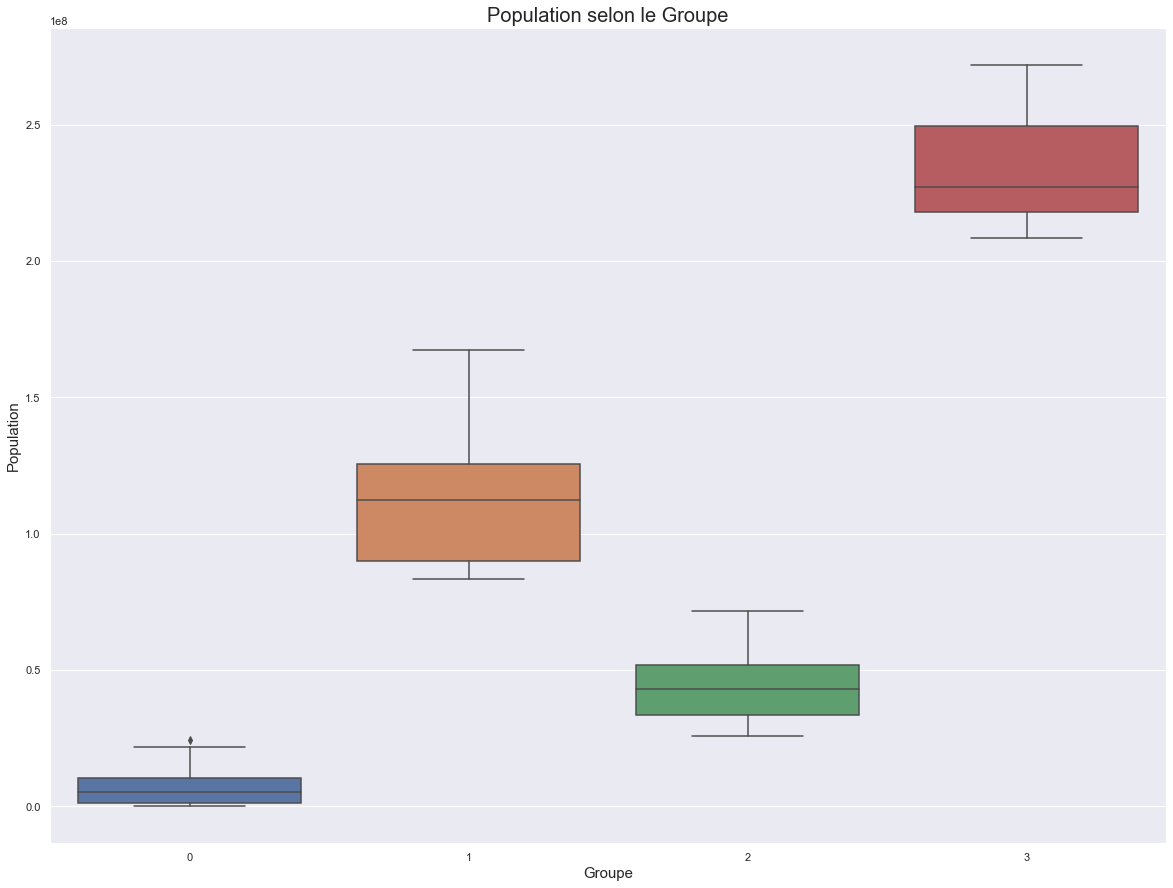

In [23]:
sns.boxplot(data = X, x= 'cluster', y='Population')
plt.xlabel('Groupe',fontsize =15)
plt.ylabel('Population',fontsize=15)
plt.title('Population selon le Groupe', fontsize=20)
plt.savefig('pop.png')

Cluster 0 : Population très faible

Cluster 1 : Population moyenne

Cluster 2 : Faible population mais plus forte que le cluster 0

Cluster 3 : Très forte population

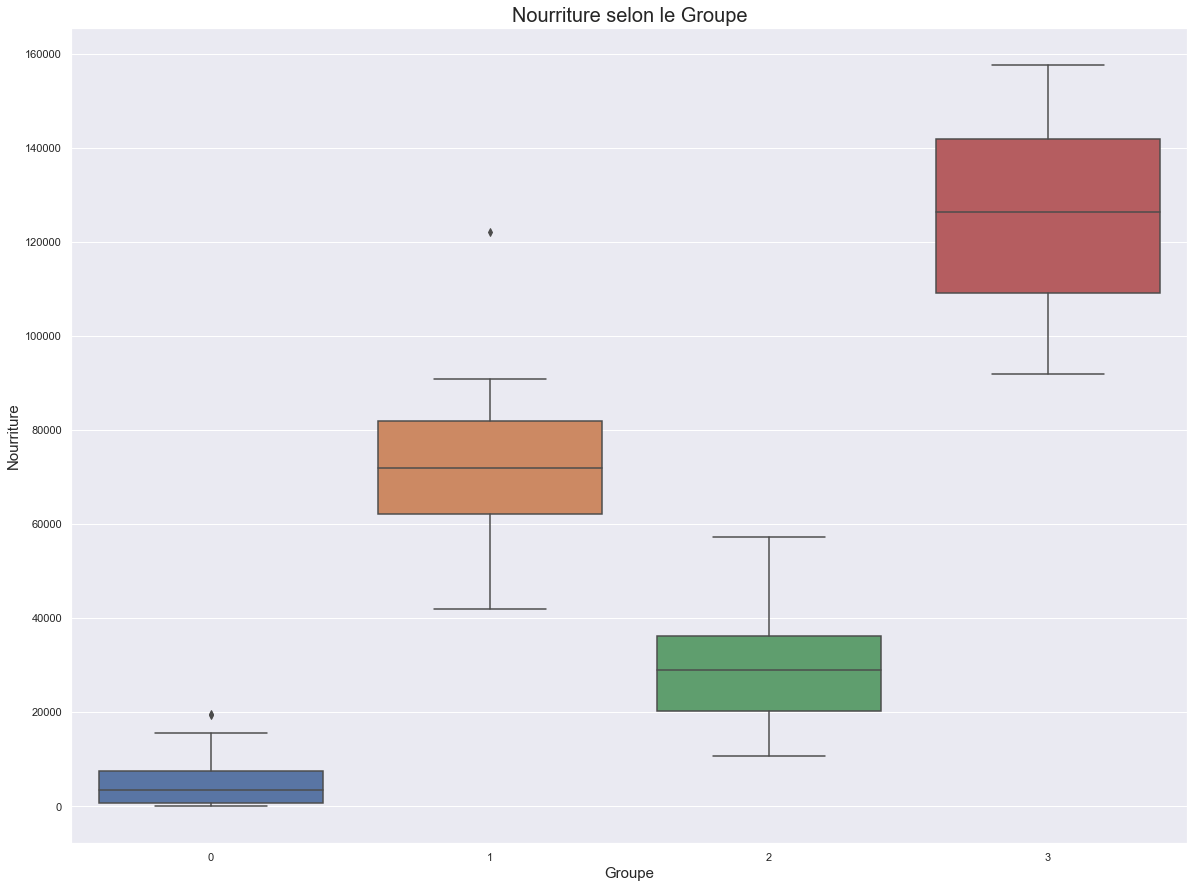

In [24]:
sns.boxplot(data = X, x= 'cluster', y='Food')
plt.xlabel('Groupe',fontsize =15)
plt.ylabel('Nourriture',fontsize=15)
plt.title('Nourriture selon le Groupe', fontsize=20)
plt.savefig('food.png')

Cluster 0 : Nourriture très faible

Cluster 1 : Nourriture moyenne

Cluster 2 : Faible nourriture mais plus forte que le cluster 0

Cluster 3 : Très forte nourriture

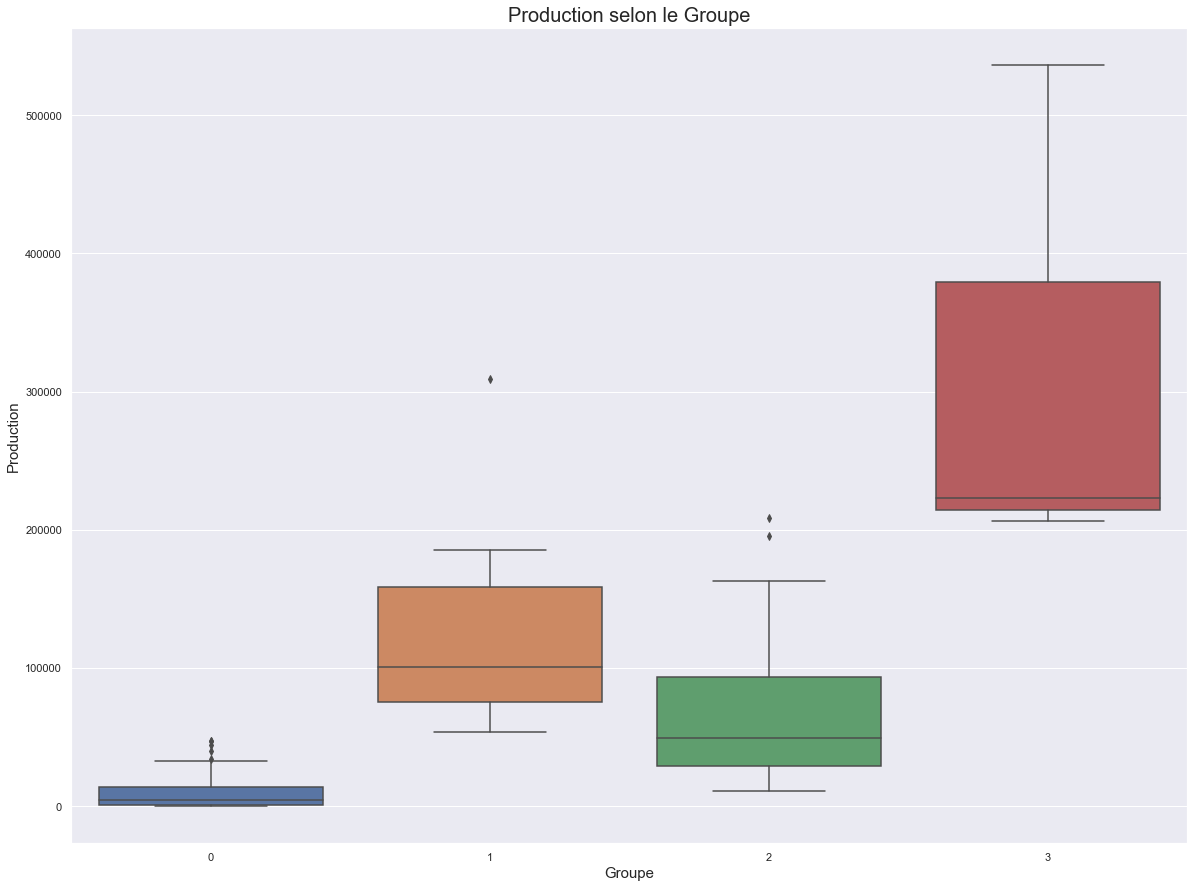

In [25]:
sns.boxplot(data = X, x= 'cluster', y='Production')
plt.xlabel('Groupe',fontsize =15)
plt.ylabel('Production',fontsize=15)
plt.title('Production selon le Groupe', fontsize=20)
plt.savefig('production.png')

Cluster 0 : Production très faible

Cluster 1 : Production faible 

Cluster 2 : Production faible mais plus forte que celle du cluster 0 et plus faible que celle du cluster 1

Cluster 3 : Très forte production

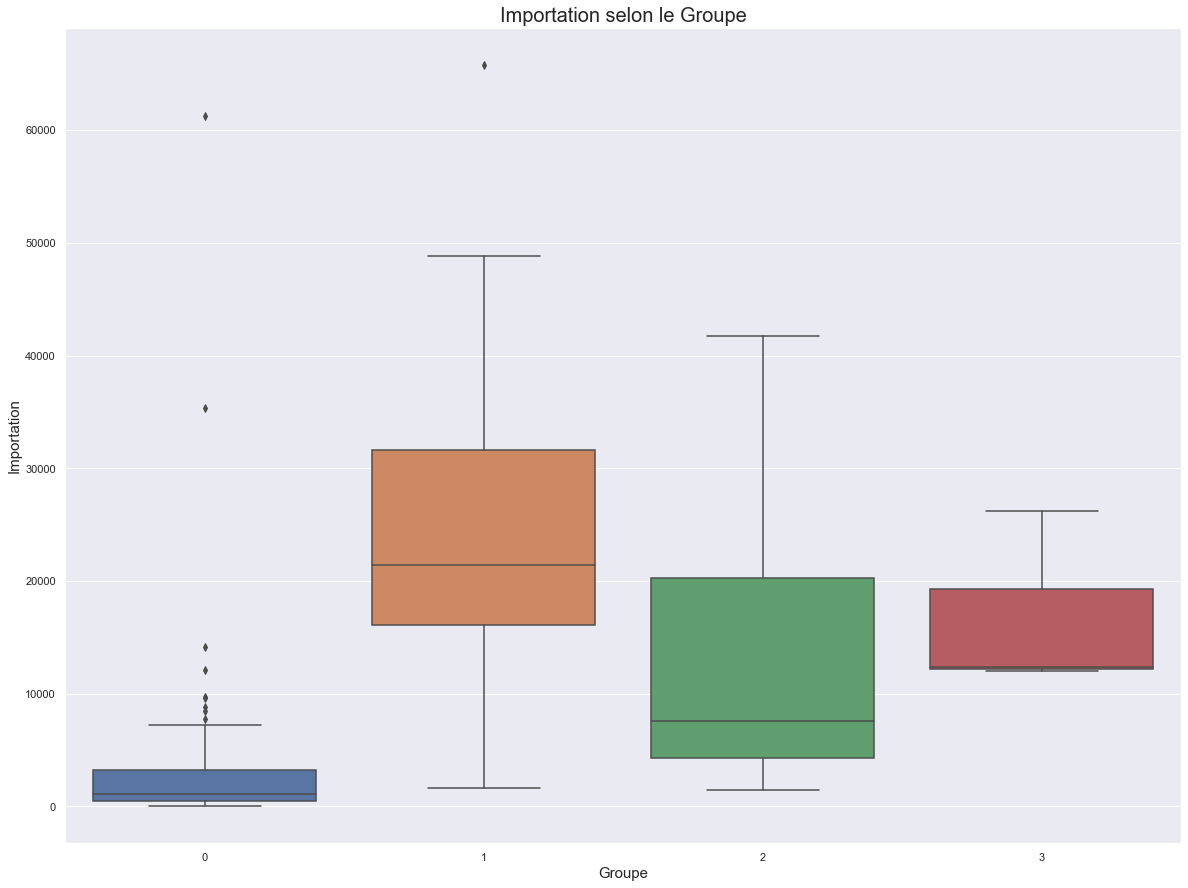

In [26]:
sns.boxplot(data = X, x= 'cluster', y='Import Quantity')
plt.xlabel('Groupe',fontsize =15)
plt.ylabel('Importation',fontsize=15)
plt.title('Importation selon le Groupe', fontsize=20)
plt.savefig('import.png')

Cluster 0 : Très faibles importations

Cluster 1 : Fortes importations

Cluster 2 : Importations moyennes

Cluster 3 : Importations moyennes plus importantes que pour le cluster 2

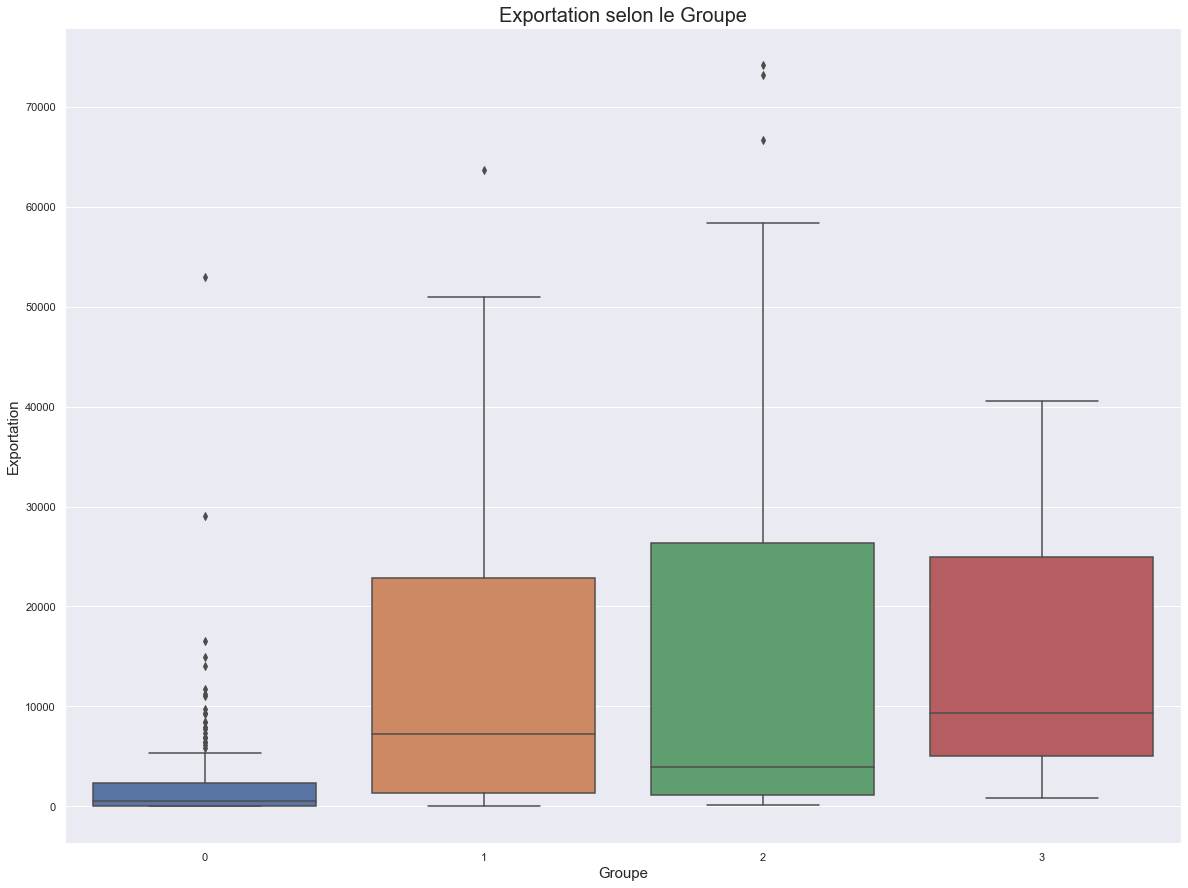

In [27]:
sns.boxplot(data = X, x= 'cluster', y='Export Quantity')
plt.xlabel('Groupe',fontsize =15)
plt.ylabel('Exportation',fontsize=15)
plt.title('Exportation selon le Groupe', fontsize=20)
plt.savefig('export.png')

Cluster 0 : Très faible export

Cluster 1, 2 et 3 : Exports moyens assez similaire

## Caractérisation des clusters via une heatmap des différentes variables

In [28]:
centroid = X.groupby(by='cluster').mean()
centroid_scaled = scaler.fit_transform(centroid)
centroid_scaled = pd.DataFrame(centroid_scaled)
centroid_scaled.columns = features

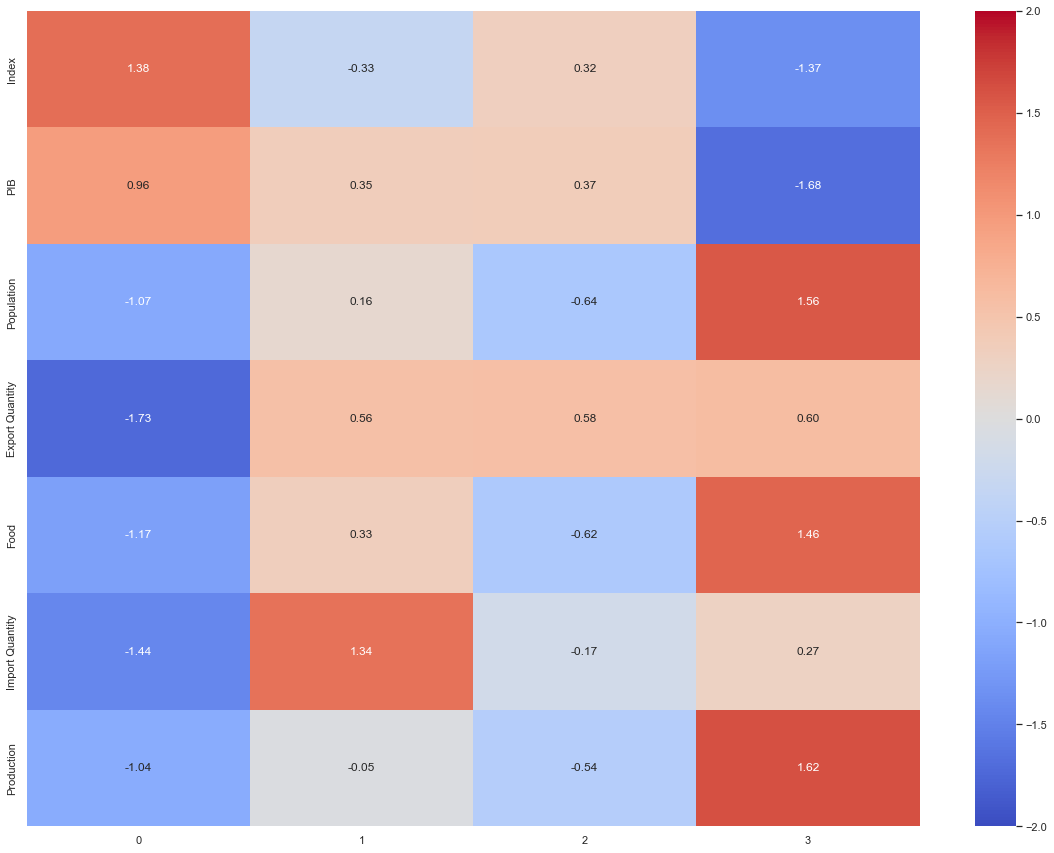

In [29]:
sns.heatmap(centroid_scaled.T, vmin=-2, vmax=2, annot=True, cmap="coolwarm", fmt="0.2f")
plt.savefig('heatmap_cen.png')

Cette carte de chaleur nous montre les différences entre les différents clusters de manière plus simple que les boxplots.

Pour résumer :
 - le cluster 0 a un très fort index de stabilité politique, de même pour son PIB. En revanche, sa population, sa nourriture, ses importations et sa production sont très faible tandis que ses exportations sont extrèmements faibles.
 

 - le cluster 1 a une production ainsi qu'une population moyenne, son index de stabilité politique est un peu faible, son PIB et sa nourriture sont un peu au-dessus de la moyenne tandis que ses exportations sont fortes et ses importations très fortes
 
 
 - le cluster 2 a sa production, sa nourriture et sa population faible, son index de stabilité politique et son PIB sont un peu au-dessus de la moyenne, ses importations sont légèrement plus faible que la moyenne tandis que ses exportations sont fortes
 
 
 - le cluster 3 a sa population, sa nourriture et sa production très fortes, ses exportations sont fortes, ses importations sont un peu au-dessus de la moyenne tandis que son index de stabilité politique et son PIB sont très faibles.

Pour rappel, la France fait partie du cluster 2.

## Classification Ascendante Hiérarchique

Pour mieux distinguer quels pays sont dans quels cluster, nous allons réaliser un dendrogramme.

In [30]:
X = acp.copy()
Z = linkage(X, method="ward")
pd.DataFrame(Z)

,0,1,2,3
0,136.0,137.0,4.162346e+03,2.0
1,135.0,141.0,4.567309e+03,2.0
2,62.0,82.0,7.552525e+03,2.0
3,100.0,156.0,8.207002e+03,2.0
4,35.0,66.0,1.078751e+04,2.0
...,...,...,...,...
165,328.0,331.0,8.384916e+07,33.0
166,330.0,334.0,9.507162e+07,11.0
167,335.0,336.0,2.644186e+08,157.0
168,333.0,337.0,2.654835e+08,14.0


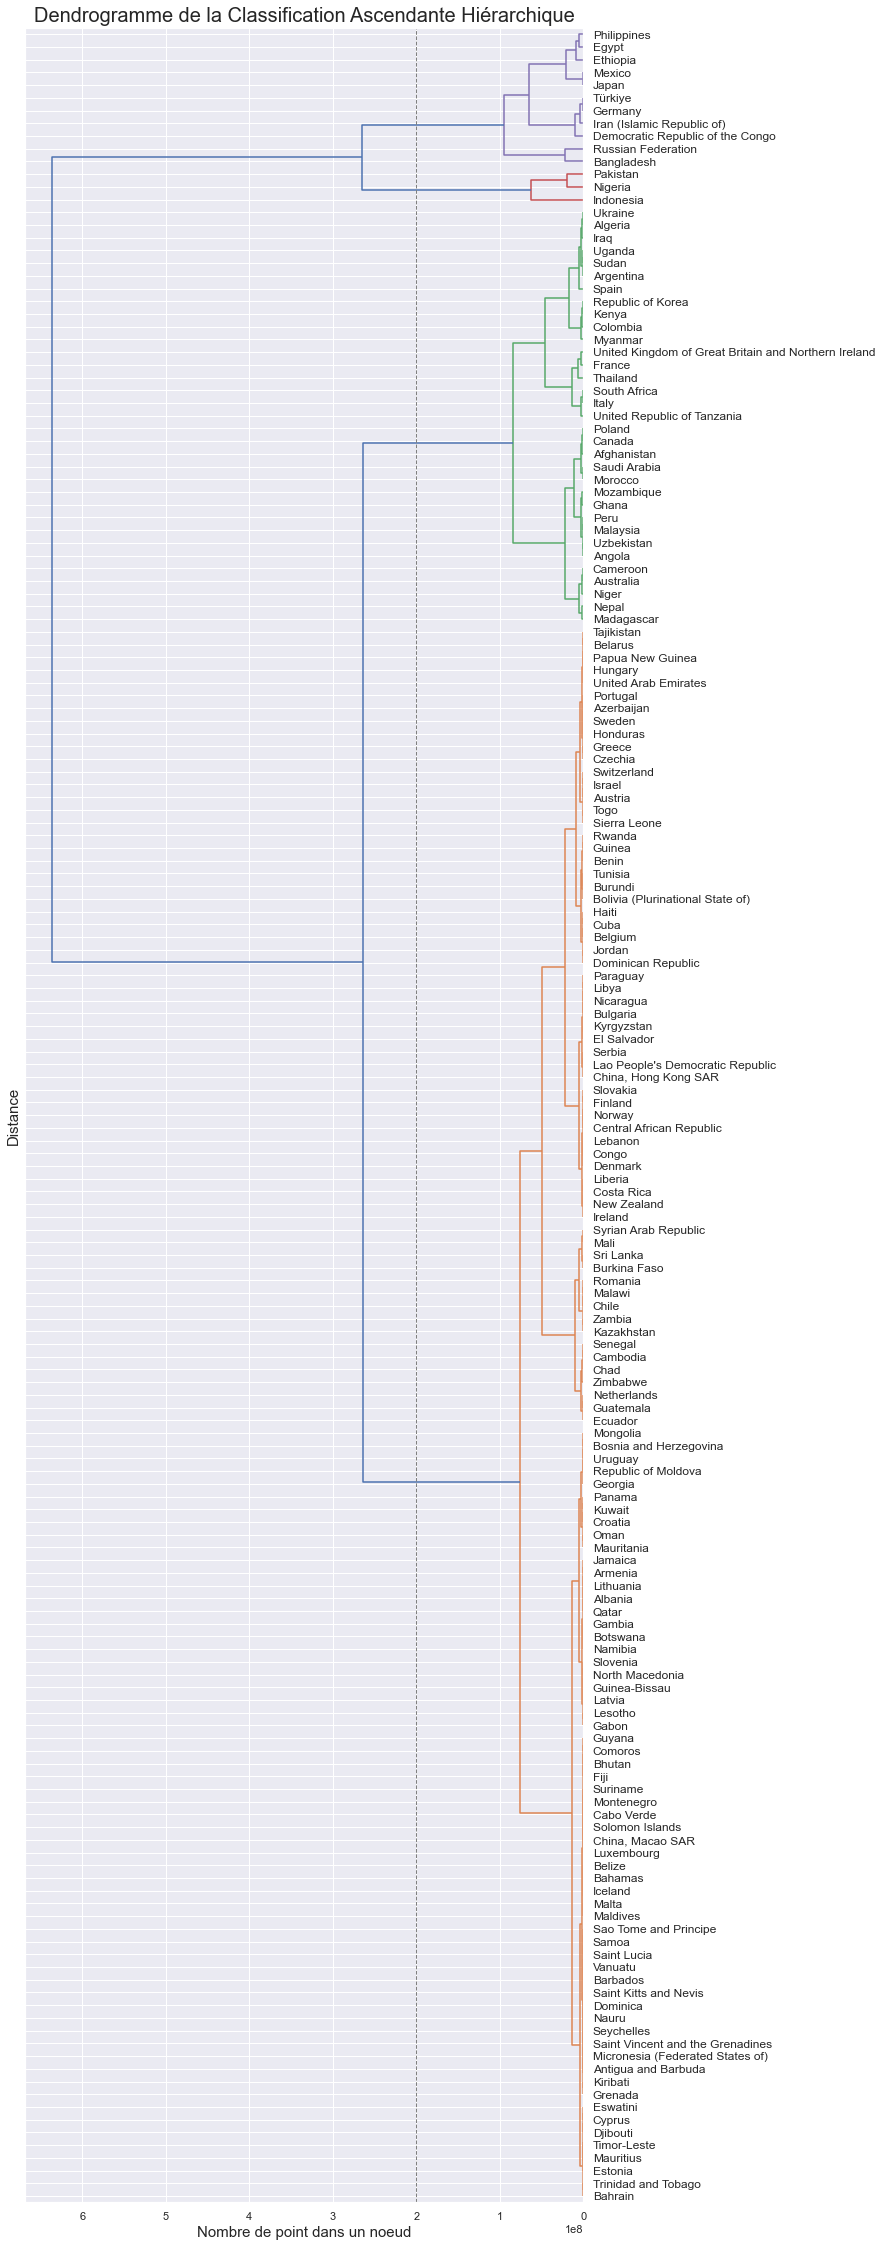

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10,40))

_ = dendrogram(Z,labels= acp.index,orientation='left', ax=ax,color_threshold=2*10**8)
set_link_color_palette(['red', 'green', 'blue'])

plt.axvline(x=2*10**8, c='grey', lw=1, linestyle='dashed')
plt.title("Dendrogramme de la Classification Ascendante Hiérarchique",fontsize=20)
plt.xlabel("Nombre de point dans un noeud",fontsize=15)
plt.ylabel("Distance",fontsize=15)
plt.yticks(fontsize=12)
plt.savefig('cah.png')
plt.show()

Nous repérons la France avec la Grande Bretagne comme 'soeur', ce qui se traduit par des caractéristiques proches.

Pour rappel, la Grande-Bretagne était l'un des pays proche de la France sur les projections

Au vu des résultats des dendrogrammes et des projections, nous allons partir sur la Grande-Bretagne pour installer le nouveau magasin en ce qui concerne l'agroalimentaire en général.


Nous allons maintenant effectuer les clustering en gardant uniquement la viande de volaille de la dataframe 'dispo' comme demandé.

# Clustering avec la viande de volaille comme critère

## Importations du fichier

In [32]:
acp = pd.read_csv('acp_volaille.csv')
acp = acp.set_index('Country')
acp = acp[(acp.index != 'China, mainland')&(acp.index != 'India')&(acp.index != 'Brazil')&(acp.index != 'United States of America')]
acp

,Index,PIB,Population,Export Quantity,Food,Import Quantity,Production
Country,,,,,,,
Afghanistan,-2.73,516.866552,38972230,0.0,67.0,36.0,28.0
Albania,0.08,5332.160475,2866849,0.0,40.0,26.0,14.0
Algeria,-0.86,3337.252512,43451666,1.0,280.0,0.0,284.0
Angola,-0.52,1603.993477,33428485,0.0,276.0,224.0,52.0
Antigua and Barbuda,0.93,14787.635775,92664,0.0,6.0,6.0,0.0
...,...,...,...,...,...,...,...
Uruguay,1.05,15619.542656,3429086,1.0,73.0,8.0,70.0
Uzbekistan,-0.44,1749.655815,33526656,0.0,104.0,44.0,66.0
Vanuatu,0.90,2877.520173,311685,0.0,4.0,4.0,1.0


## Séparation des données

In [33]:
X = acp.values
names = acp.index
features = acp.columns

## Centrer-Réduire

In [34]:
scaler = StandardScaler()

In [35]:
X_scaled = scaler.fit_transform(X)

In [36]:
idx = ["mean", "std"]

pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

,0,1,2,3,4,5,6
mean,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## Initialisation de l'analyse en composante principale

In [37]:
n_components = 6
pca = PCA(n_components=n_components)
pca.fit(X_scaled)

PCA(n_components=6)

## Initialisation de la méthode du Kmeans avec la méthode du coude

In [38]:
# Une liste vide pour enregistrer les inerties :  
intertia_list = [ ]

# Notre liste de nombres de clusters : 
k_list = range(1, 10)

# Pour chaque nombre de clusters : 
for k in k_list : 
    
    # On instancie un k-means pour k clusters
    kmeans = KMeans(n_clusters=k)
    
    # On entraine
    kmeans.fit(X)
    
    # On enregistre l'inertie obtenue : 
    intertia_list.append(kmeans.inertia_)

C:\Users\Elenweii\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


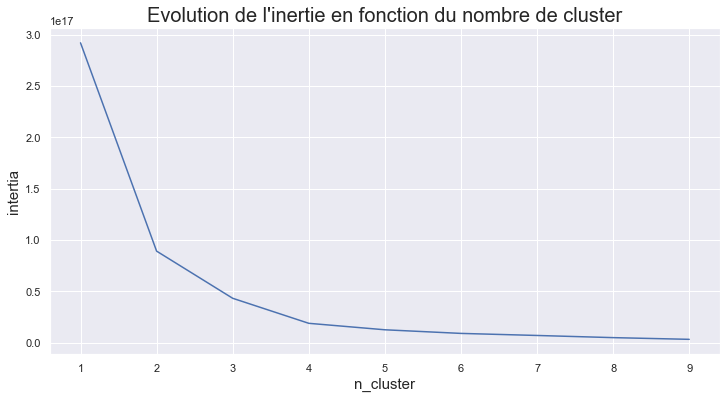

In [39]:
fig, ax = plt.subplots(1,1,figsize=(12,6))

ax.set_ylabel("intertie",fontsize=15)
ax.set_xlabel("n_cluster",fontsize=15)
plt.title('Evolution de l\'inertie en fonction du nombre de cluster',fontsize=20)
ax = plt.plot(k_list, intertia_list)
plt.savefig('coude_kmeans.png')

Ici aussi, nous constatons une dernière cassure pour 4 clusters.

## Projections sur un plan factoriel des clusters avec leur centroïdes

In [40]:
X_proj = pca.transform(X_scaled)

In [41]:
kmeans = KMeans(n_clusters=4,random_state=42)
kmeans.fit(X)

KMeans(n_clusters=4, random_state=42)

In [42]:
X = acp.copy()
labels = kmeans.labels_
X["cluster"] = labels
X

,Index,PIB,Population,Export Quantity,Food,Import Quantity,Production,cluster
Country,,,,,,,,
Afghanistan,-2.73,516.866552,38972230,0.0,67.0,36.0,28.0,2
Albania,0.08,5332.160475,2866849,0.0,40.0,26.0,14.0,0
Algeria,-0.86,3337.252512,43451666,1.0,280.0,0.0,284.0,2
Angola,-0.52,1603.993477,33428485,0.0,276.0,224.0,52.0,2
Antigua and Barbuda,0.93,14787.635775,92664,0.0,6.0,6.0,0.0,0
...,...,...,...,...,...,...,...,...
Uruguay,1.05,15619.542656,3429086,1.0,73.0,8.0,70.0,0
Uzbekistan,-0.44,1749.655815,33526656,0.0,104.0,44.0,66.0,2
Vanuatu,0.90,2877.520173,311685,0.0,4.0,4.0,1.0,0


In [43]:
centroids = kmeans.cluster_centers_
centroids_scaled = scaler.transform(centroids)
centroids_proj = pca.transform(centroids_scaled)
centroids_proj = pd.DataFrame(centroids_proj)

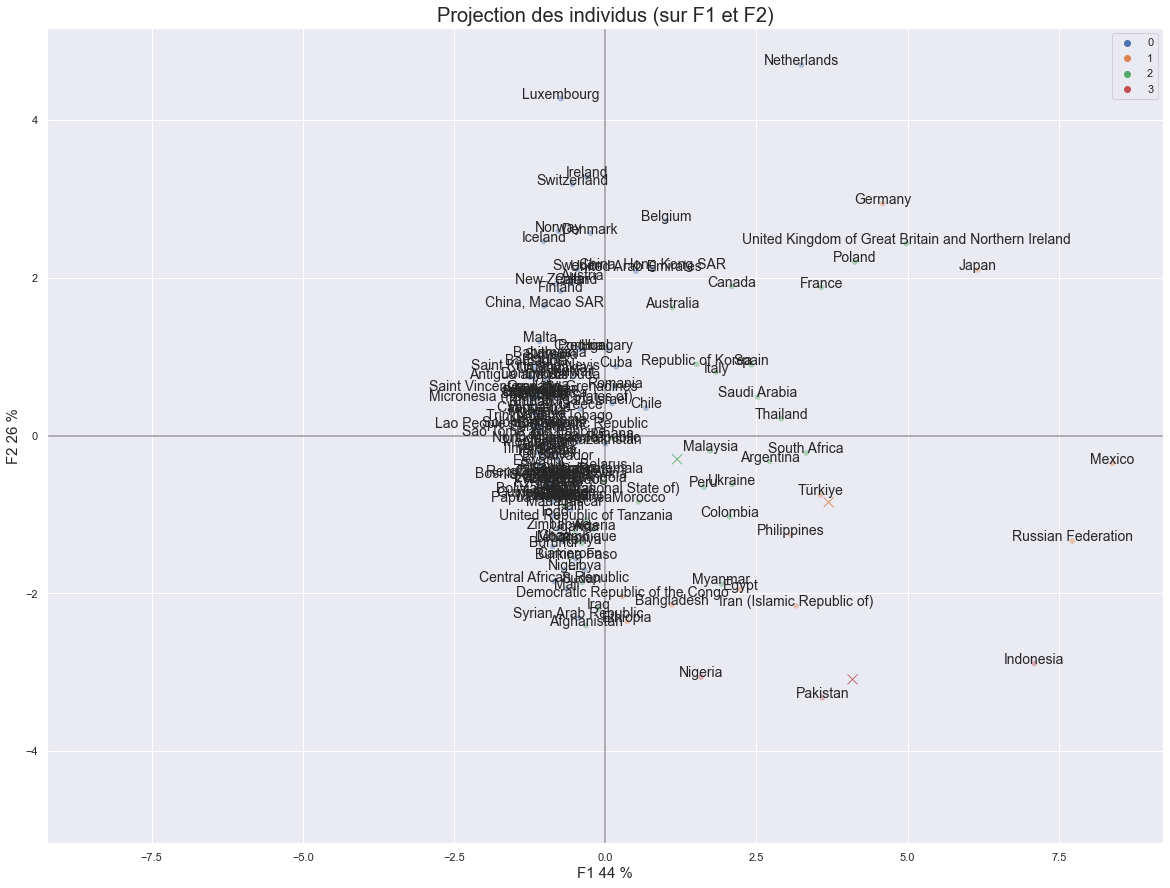

In [44]:
display_with_centroids(X_proj,centroids_proj, (0,1), pca, labels = names, clusters=labels, figsize=(20,15), marker="o")

Ici, nous constatons que laFrance est proche de la Pologne, du Canada, de l'Espagne, du Royaume-Uni,de l'Australie, de l'Allemagne et du Japon.

Ces deux derniers font partis d'un cluster différent de celui de la France.

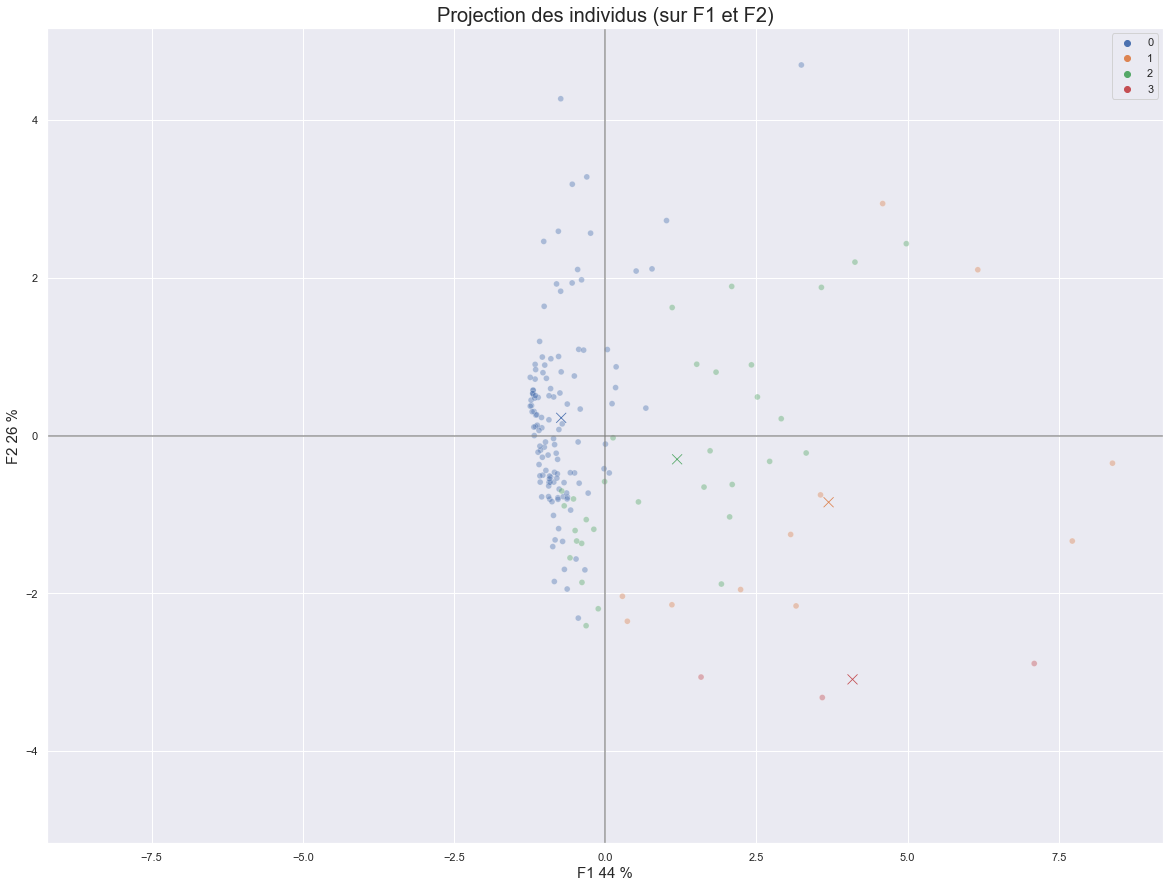

In [45]:
display_with_centroids(X_proj,centroids_proj, (0,1), pca, clusters=labels, figsize=(20,15), marker="o")

Les observations sont assez similaires aux projections avec tous les produits.

De gauche à droite, nous avons :
 - le premier centroïde représente un individu moyen avec un PIB par habitant et un index de stabilité politique moyen tandis que sa population, sa production et sa nourriture sont un peu plus faibles que la moyenne.
 
 
 - le second centroïde représente un individu avec un PIB et un index assez similaire au premier mais sa population, sa production et sa nourriture sont un peu plus importantes que la moyenne.
 
 
 - le troisième centroïde représente un individu avec un PIB et un index plus faible que la moyenne, en revanche sa nourriture, sa production et sa population sont importantes.
 
 
 - le dernier centroïde représente un individu avec un PIB et un index très faible, et sa population, sa production et sa nourriture sont assez similaires à celles du troisième centroïde.

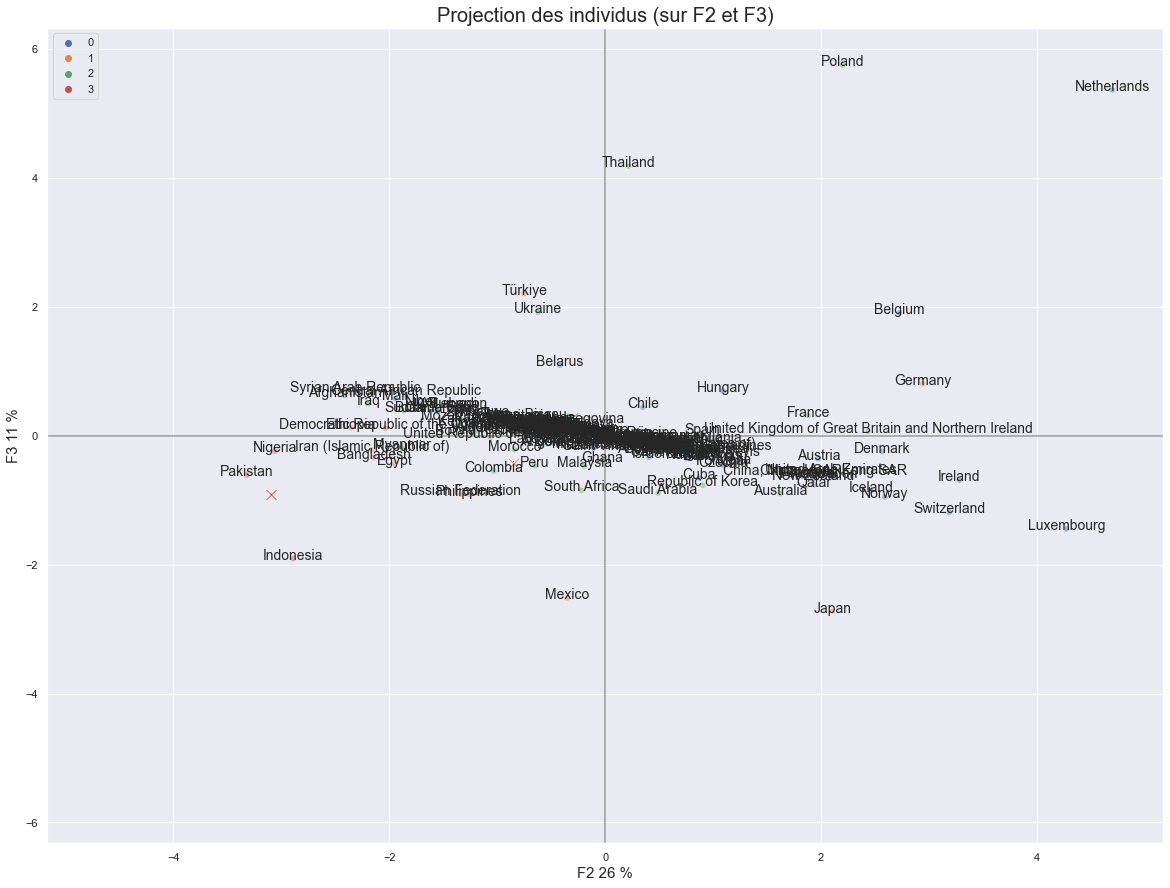

In [46]:
display_with_centroids(X_proj,centroids_proj, (1,2), pca, labels = names, clusters=labels, figsize=(20,15), marker="o")

Ici, nous pouvons voir la France près de l'Allemagne, de l'Hongrie, de la Belgique, de l'Autriche, du Danemark et du Royaume-Uni.

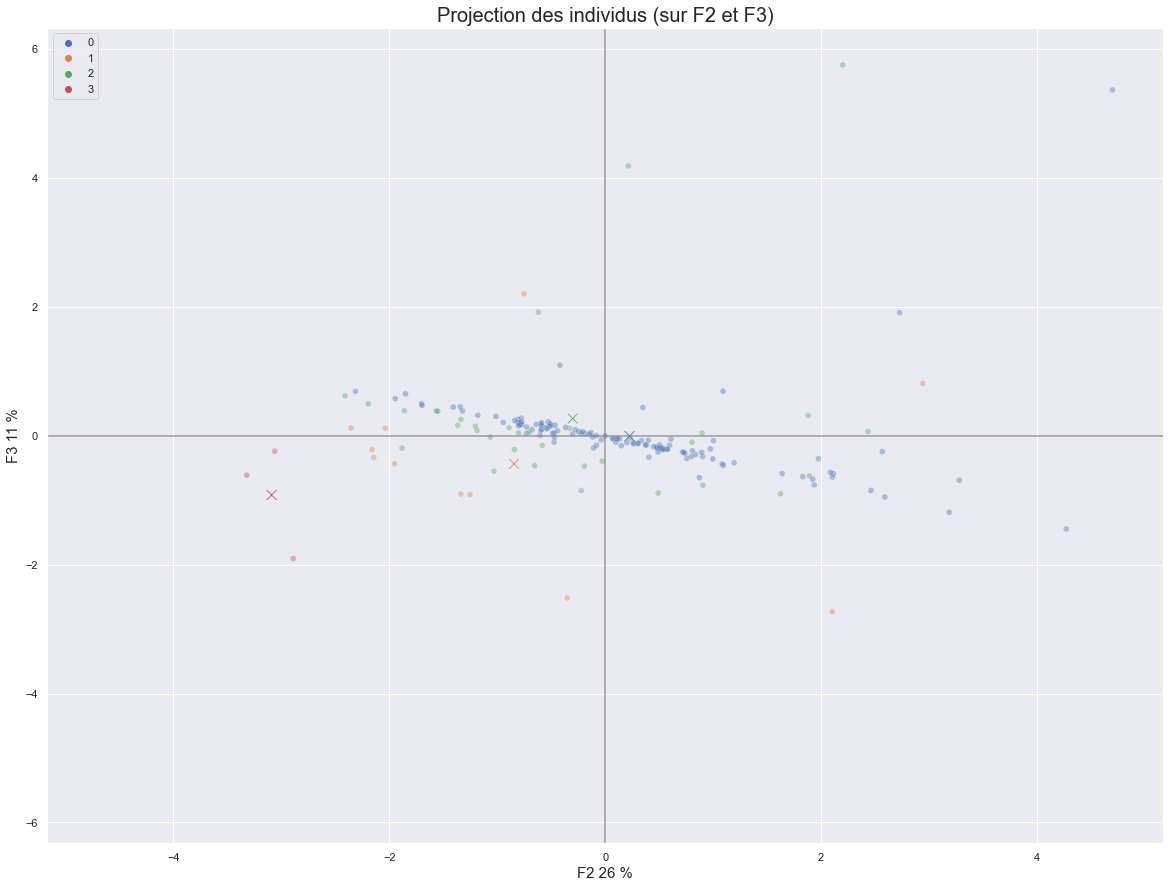

In [47]:
display_with_centroids(X_proj,centroids_proj, (1,2), pca, clusters=labels, figsize=(20,15), marker="o")

De gauche à droite, nous avons :
 - le premier centroïde traduit un individu ayant de faibles exportations et de très faibles importations
 
 - le second centroïde a des exportations un peu plus importantes que le premier mais toujours plus faibles que la moyenne, avec des importations bien plus importantes mais toujours inférieures à la moyenne
 
 - les troisième et quatrième centroïdes ont des exportations ainsi que des importations moyennes 

## Caractérisation des clusters via des boxplots des différentes variables

Comme les caractéristiques seront également expliquées via une heatmap plus loin, ces graphes ne seront pas expliqués.

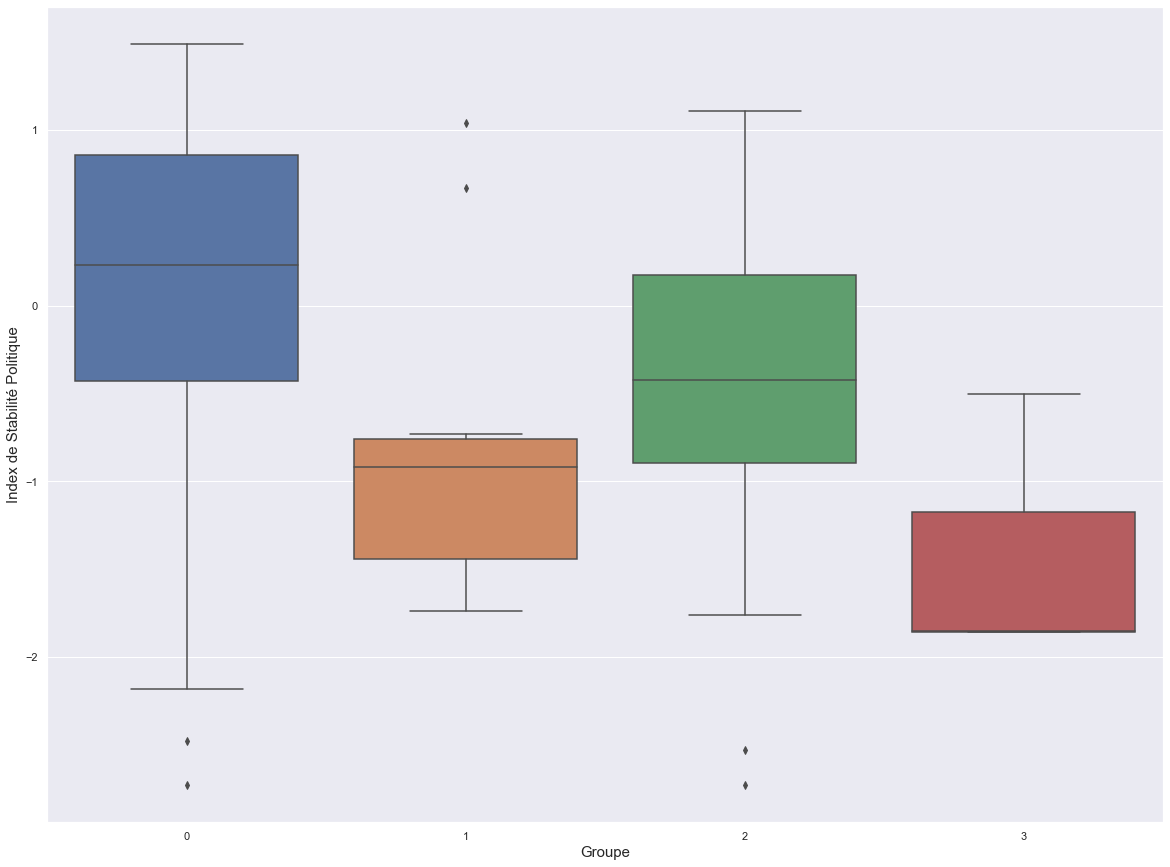

In [48]:
sns.boxplot(data = X, x= 'cluster', y='Index')
plt.xlabel('Groupe',fontsize =15)
plt.ylabel('Index de Stabilité Politique',fontsize=15)
plt.savefig('index.png')

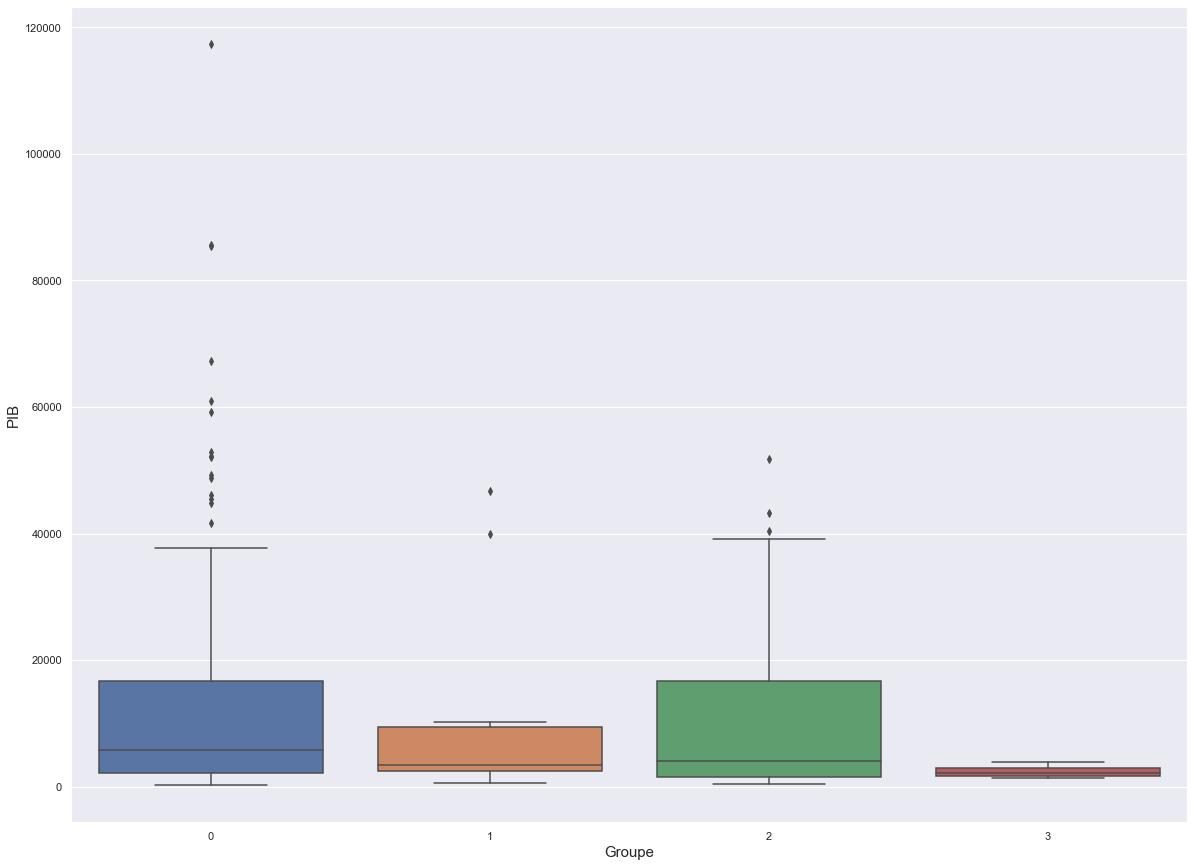

In [49]:
sns.boxplot(data = X, x= 'cluster', y='PIB')
plt.xlabel('Groupe',fontsize =15)
plt.ylabel('PIB',fontsize=15)
plt.savefig('pib.png')

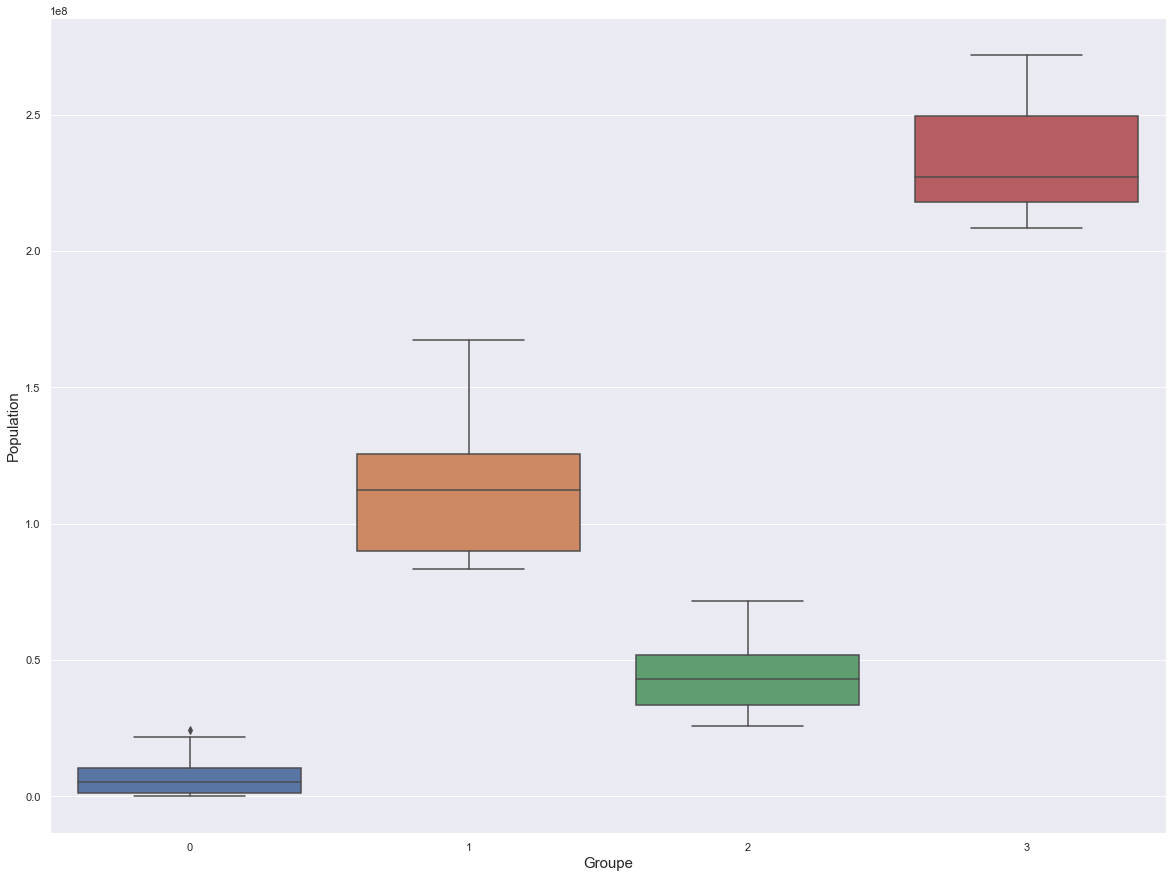

In [50]:
sns.boxplot(data = X, x= 'cluster', y='Population')
plt.xlabel('Groupe',fontsize =15)
plt.ylabel('Population',fontsize=15)
plt.savefig('pop.png')

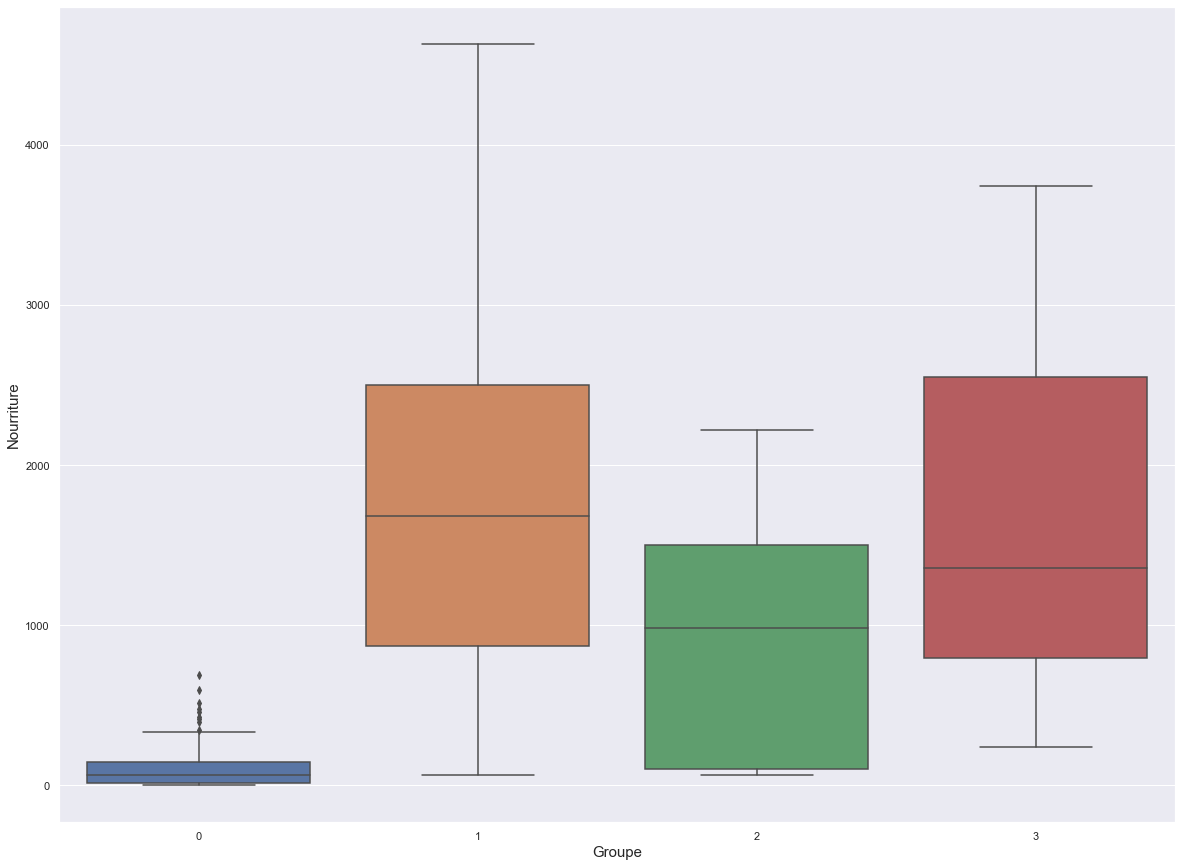

In [51]:
sns.boxplot(data = X, x= 'cluster', y='Food')
plt.xlabel('Groupe',fontsize =15)
plt.ylabel('Nourriture',fontsize=15)
plt.savefig('food.png')

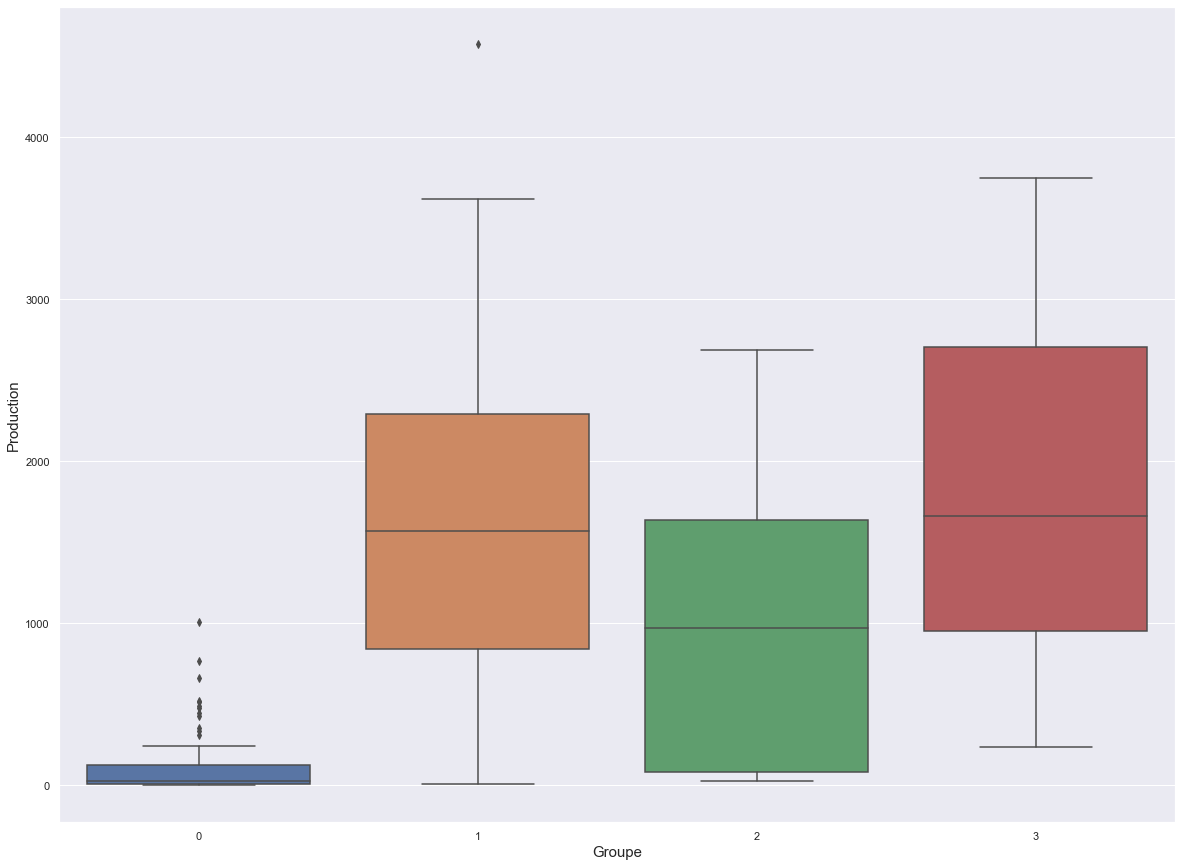

In [52]:
sns.boxplot(data = X, x= 'cluster', y='Production')
plt.xlabel('Groupe',fontsize =15)
plt.ylabel('Production',fontsize=15)
plt.savefig('production.png')

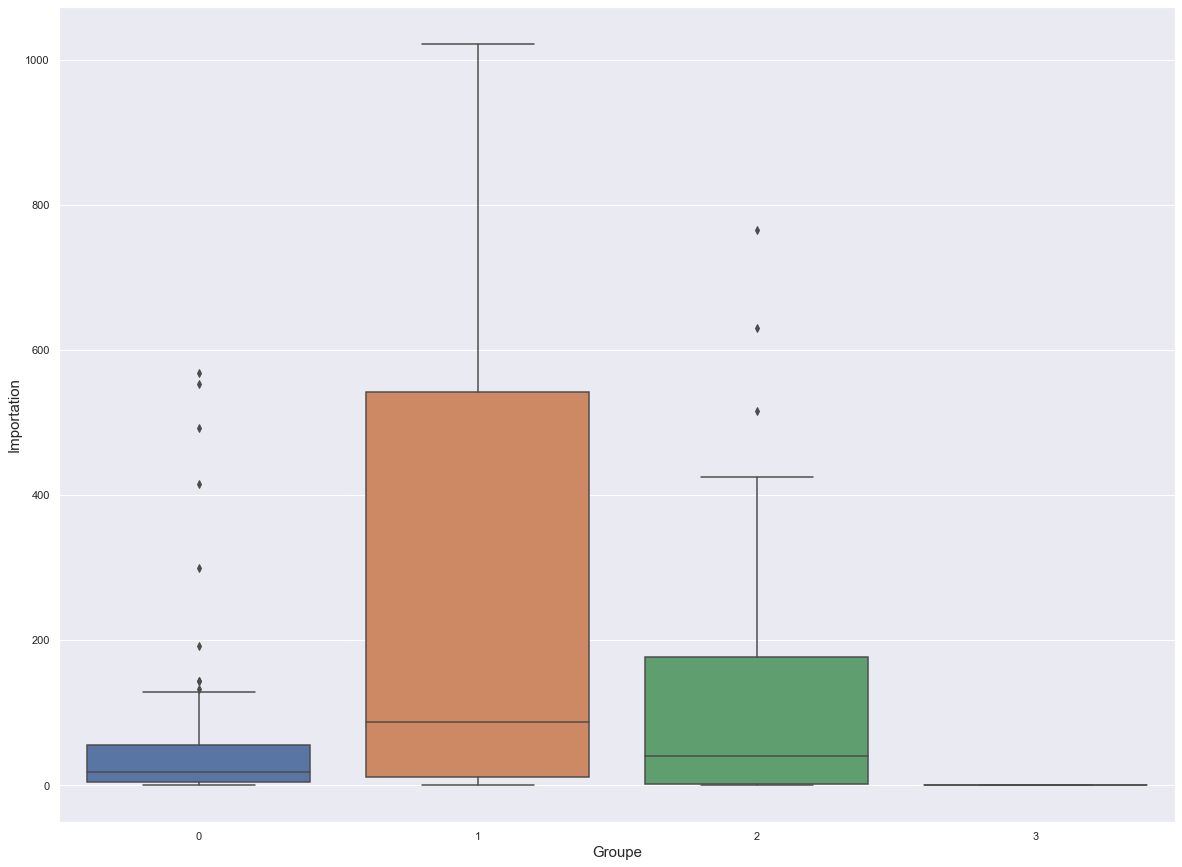

In [53]:
sns.boxplot(data = X, x= 'cluster', y='Import Quantity')
plt.xlabel('Groupe',fontsize =15)
plt.ylabel('Importation',fontsize=15)
plt.savefig('import.png')

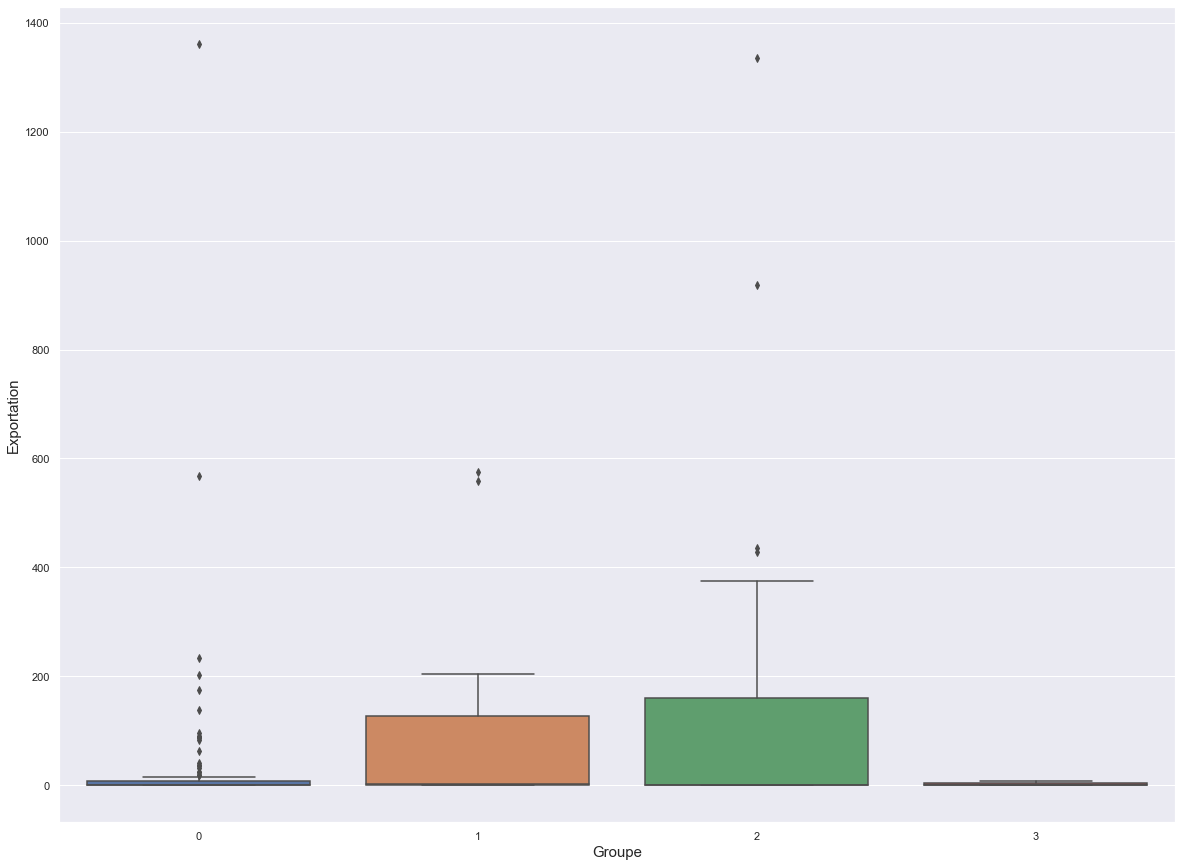

In [54]:
sns.boxplot(data = X, x= 'cluster', y='Export Quantity')
plt.xlabel('Groupe',fontsize =15)
plt.ylabel('Exportation',fontsize=15)
plt.savefig('export.png')

## Caractérisation des clusters via une heatmap des différentes variables

In [55]:
centroid = X.groupby(by='cluster').mean()
centroid_scaled = scaler.fit_transform(centroid)
centroid_scaled = pd.DataFrame(centroid_scaled)
centroid_scaled.columns = features

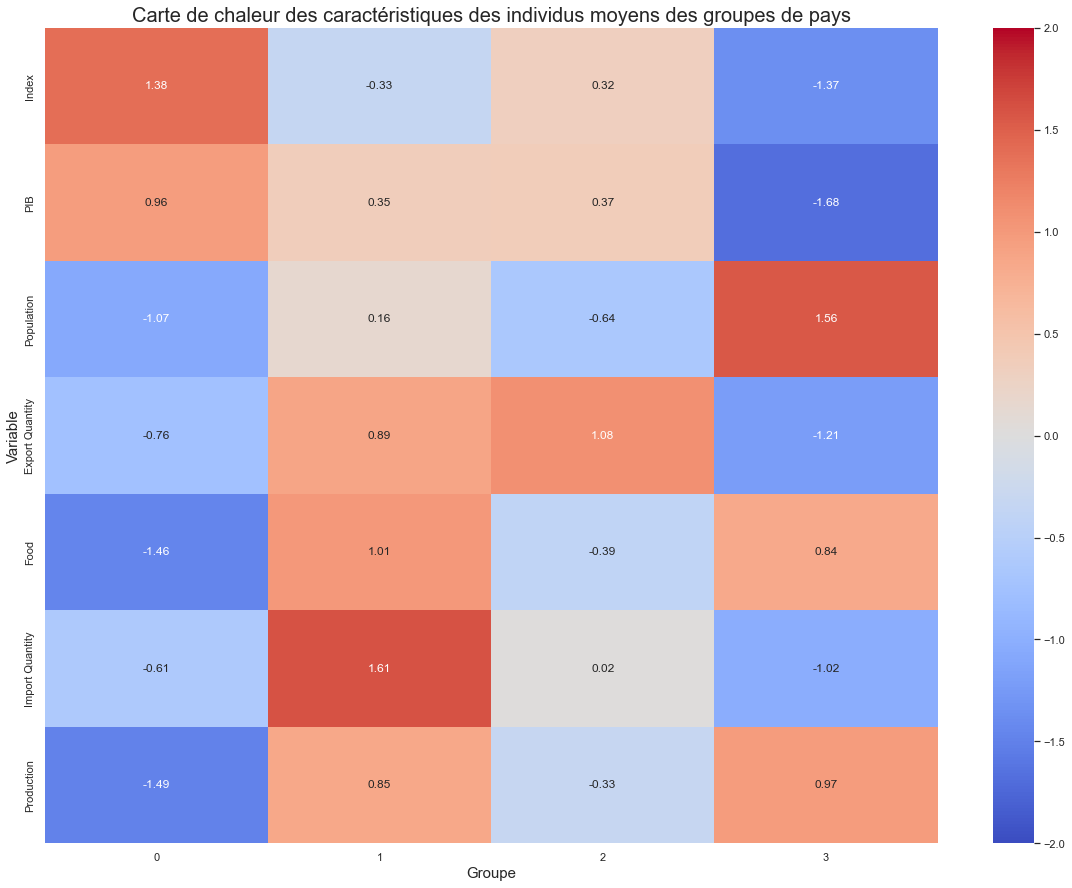

In [56]:
sns.heatmap(centroid_scaled.T, vmin=-2, vmax=2, annot=True, cmap="coolwarm", fmt="0.2f")
plt.xlabel('Groupe',fontsize =15)
plt.ylabel('Variable',fontsize=15)
plt.title('Carte de chaleur des caractéristiques des individus moyens des groupes de pays', fontsize=20)
plt.savefig('heatmap_cen.png')

Pour les caractéristiques des individus moyens des clusters, nous avons :

- Groupe 0 : Très fort index de stabilité politique, fort PIB par Habitant, très faible nourriture et production et faible population, exportation et importation
 
 
 - Groupe 1 : Très forte importation, forte production, nourriture et exportation, population et PIB au-dessus de la moyenne et index en-dessous de la moyenne
 
 
 - Groupe 2 : Forte exportation, index et PIB au-dessus de la moyenne, importation dans la moyenne, la production et la nourriture en-dessous de la moyenne et la population faible
 
 
 - Groupe 3 : Très forte population, forte production et nourriture, faible importation et exportation et très faible index et PIB

## Classification Ascendante Hiérarchique

In [57]:
X = acp.copy()
Z = linkage(X, method="ward")
pd.DataFrame(Z)

,0,1,2,3
0,136.0,137.0,4.161612e+03,2.0
1,135.0,141.0,4.562972e+03,2.0
2,62.0,82.0,7.545746e+03,2.0
3,100.0,156.0,7.660259e+03,2.0
4,39.0,67.0,1.024395e+04,2.0
...,...,...,...,...
165,328.0,331.0,8.384901e+07,33.0
166,330.0,334.0,9.507143e+07,11.0
167,335.0,336.0,2.644182e+08,157.0
168,333.0,337.0,2.654832e+08,14.0


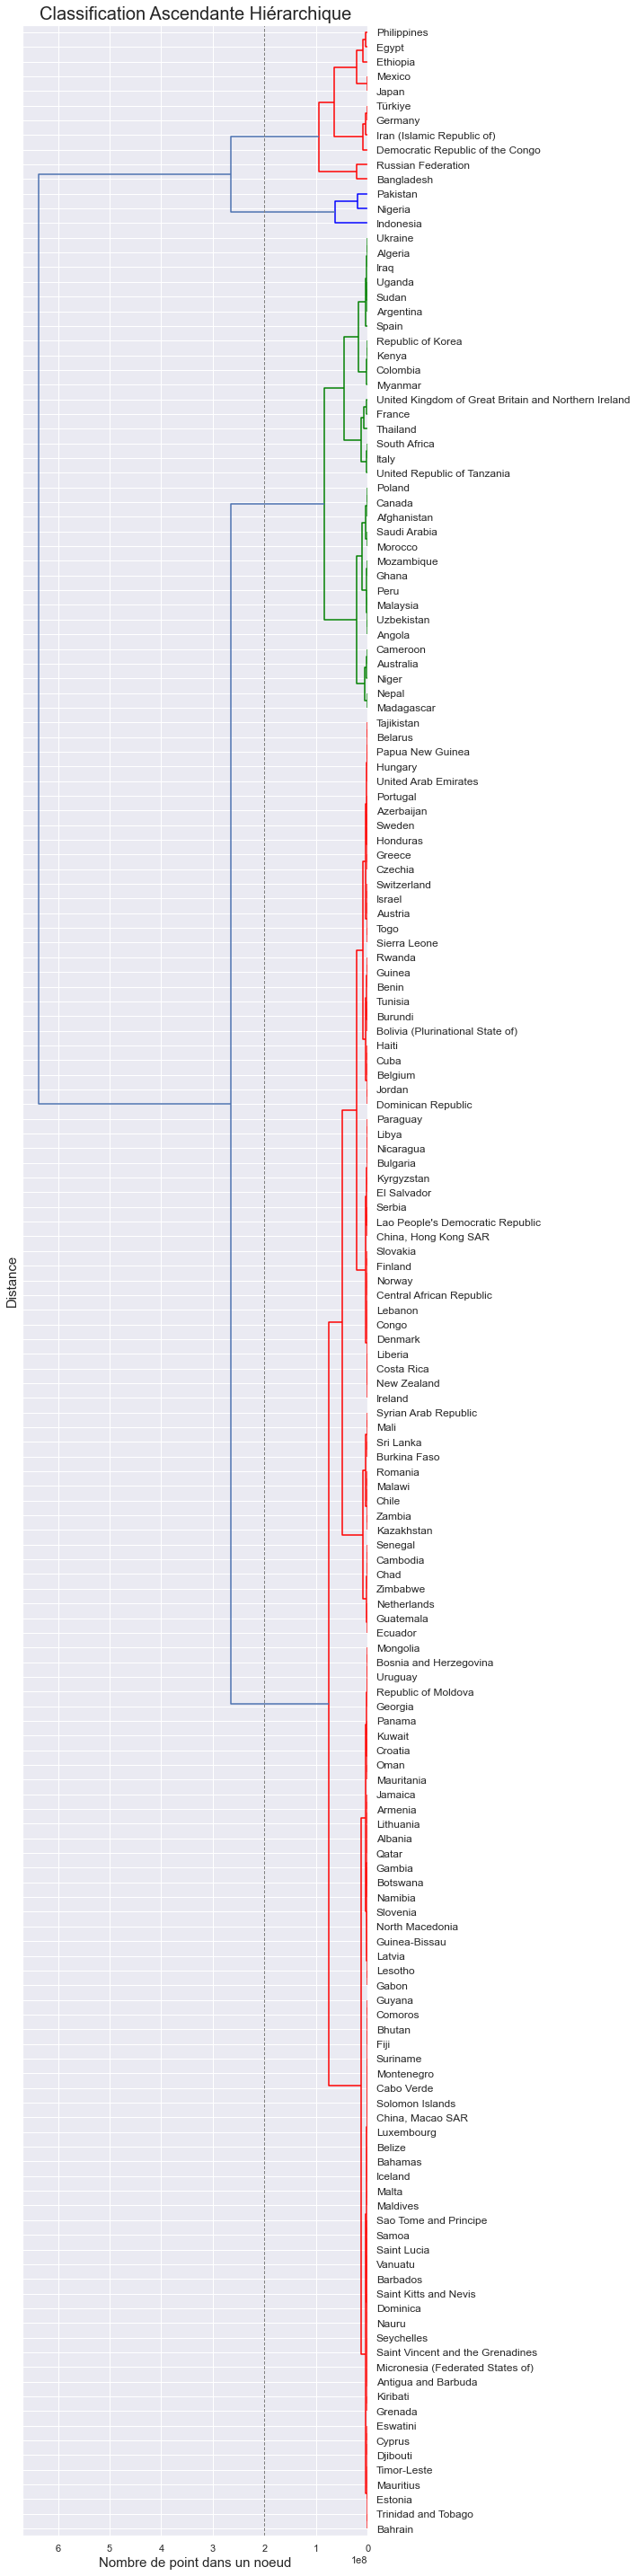

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(10,40))

_ = dendrogram(Z,labels= acp.index,orientation='left', ax=ax,color_threshold=2*10**8)
set_link_color_palette(['red', 'green', 'blue'])

plt.axvline(x=2*10**8, c='grey', lw=1, linestyle='dashed')
plt.title("Classification Ascendante Hiérarchique",fontsize=20)
plt.xlabel("Nombre de points dans un noeud",fontsize=15)
plt.ylabel("Distance",fontsize=15)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('cah.png')
plt.show()

De haut en bas, nous avons :
 - cluster 1
 - cluster 3
 - cluster 2
 - cluster 0

Pour rappel, c'est le cluster 1 qui contient les pays avec les importations les plus importantes de viandes de volailles.

Ces donc sur ces pays qu'il faudra se concentrer pour de futures analyses.

# Analyses de l'Allemagne

Comme nous l'avons dis dans le premier notebook, nous allons maintenant comparer les analyses de la France à ceux d'un pays du groupe retenu.

Ce sera l'Allemagne puisque sur les projections, ce pays était proche de la France et qu'il fait partit du cluster 1.

## Fichiers

Nous allons commencer par importer nos quatres jeux de données précédement nettoyés.

In [59]:
dispo = pd.read_csv('dispo.csv')
PIB = pd.read_csv('PIB.csv')
pol = pd.read_csv('pol.csv')
pop = pd.read_csv('pop.csv')

## Listes

Nous allons ensuite recréer les listes des produits utilisés dans le premier notebook pour regarder les différentes répartitions.

In [60]:
cereales  = ['Barley and products','Cereals, Other','Maize and products','Millet and products','Oats','Rice and products',
            'Rye and products','Sorghum and products','Wheat and products']

In [61]:
edulcorants = ['Honey','Sugar (Raw Equivalent)','Sugar beet','Sugar cane','Sugar non-centrifugal','Sweeteners, Other']

In [62]:
prod_veg = ['Apples and products','Bananas','Citrus, Other','Coconuts - Incl Copra','Dates','Fruits, other',
          'Grapefruit and products','Grapes and products (excl wine)','Groundnuts','Lemons, Limes and products',
          'Nuts and products','Olives (including preserved)','Pimento','Pineapples and products','Plantains',
          'Tomatoes and products','Cocoa Beans and products','Coffee and products','Palm kernels','Rape and Mustardseed',
          'Sesame seed','Sunflower seed','Beans','Cassava and products','Onions','Peas','Potatoes and products',
          'Pulses, Other and products','Roots, Other','Soyabeans','Sweet potatoes','Vegetables, other','Yams',
            'Oranges, Mandarines','Aquatic Plants','Oilcrops, Other','Coconut Oil','Cottonseed Oil','Groundnut Oil',
            'Maize Germ Oil','Oilcrops Oil, Other','Olive Oil','Palm Oil','Palmkernel Oil','Rape and Mustard Oil',
            'Ricebran Oil','Sesameseed Oil','Soyabean Oil','Sunflowerseed Oil']

In [63]:
prod_animaliers = ['Bovine Meat','Butter, Ghee','Cream','Eggs','Fats, Animals, Raw','Meat, Other','Meat, Aquatic Mammals',
                   'Milk - Excluding Butter','Mutton & Goat Meat','Offals, Edible','Pigmeat','Poultry Meat',
                   'Aquatic Animals, Others','Cephalopods','Crustaceans','Demersal Fish','Fish, Body Oil','Fish, Liver Oil',
                   'Freshwater Fish','Marine Fish, Other','Molluscs, Other','Pelagic Fish']

In [64]:
autres = ['Infant food','Miscellaneous','Cloves','Pepper','Spices, Other','Beer',
          'Beverages, Alcoholic','Beverages, Fermented','Tea (including mate)','Wine']

Nous pouvons maintenant passer aux analyses

## Analyses des données

### Evolution de la population

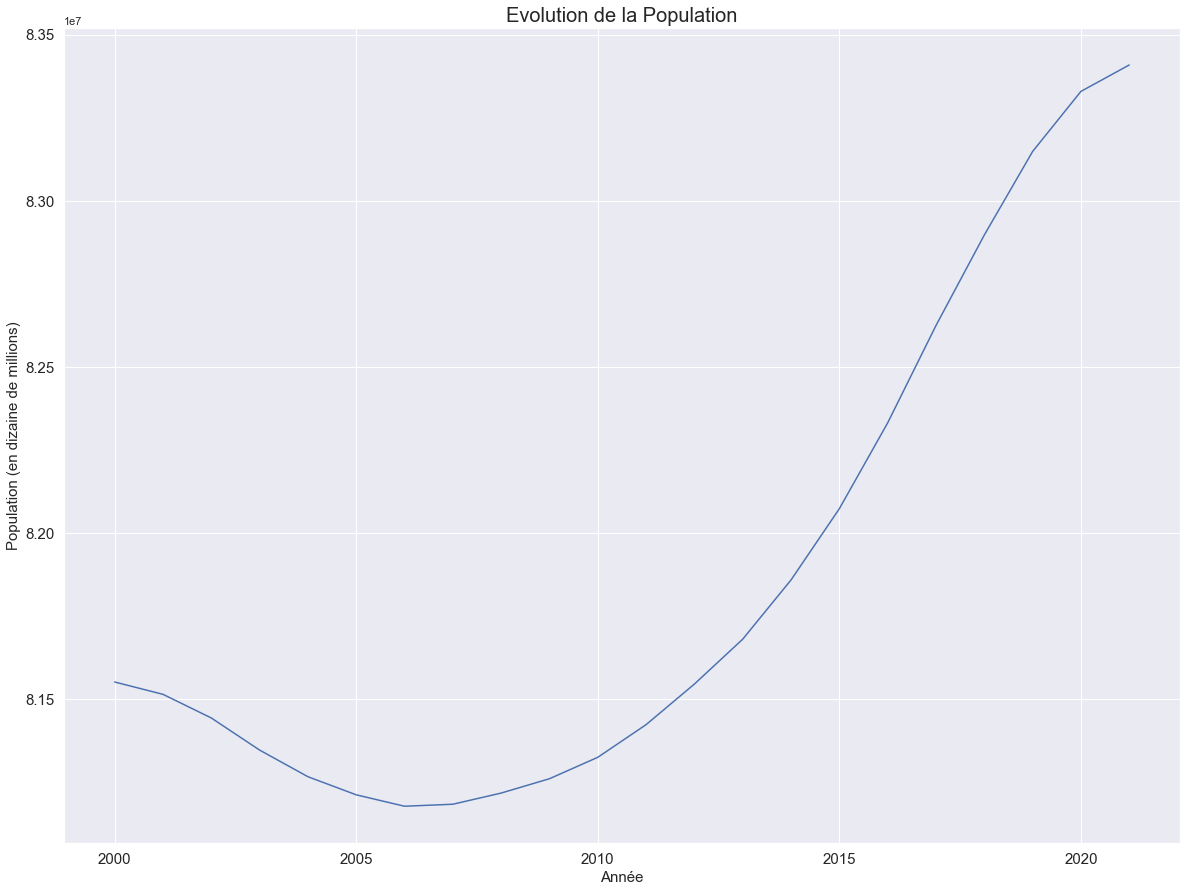

In [65]:
sns.lineplot(data = pop[pop['Country']=='Germany'], 
             x = 'Year', y = 'Population', estimator = sum)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Évolution de la Population", fontsize = 20)
plt.xlabel("Année",fontsize = 15)
plt.ylabel("Population (en dizaine de millions d'habitants)", fontsize = 15)
plt.savefig('evolution_pop_GB.png')
plt.show()

Ce graphique nous montre que l'Allemagne a une population bien plus importante que la France.

### Evolution de la stabilité politique

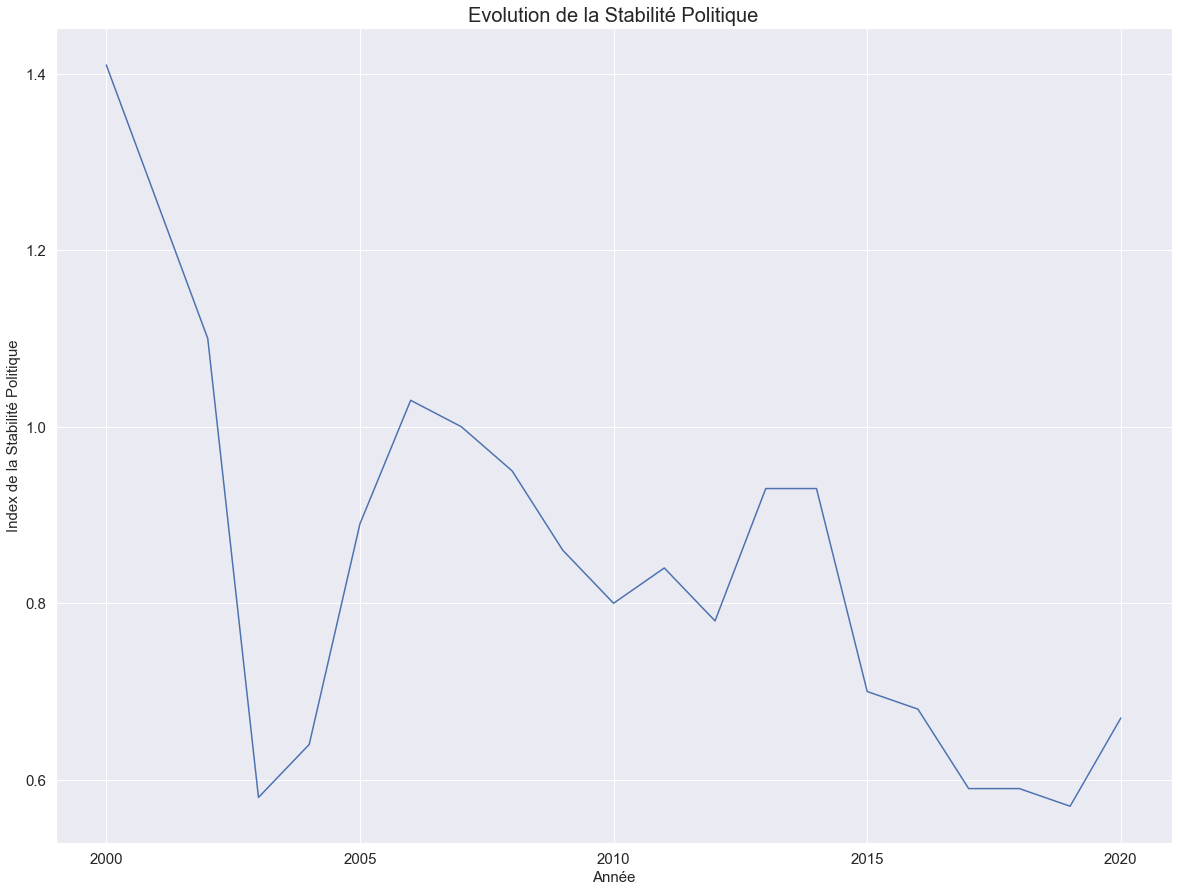

In [66]:
sns.lineplot(data = pol[pol['Country']=='Germany'], x = 'Year', y = 'Index')
plt.xticks([2000,2005,2010,2015,2020],fontsize=15)
plt.yticks(fontsize=15)
plt.title("Évolution de la Stabilité Politique", fontsize = 20)
plt.xlabel("Année",fontsize = 15)
plt.ylabel("Index de la Stabilité Politique", fontsize = 15)
plt.savefig('evolution_pol_GB.png')
plt.show()

Le premier point que nous pouvons constater que, contrairement à la France, l'index de l'Allemagne n'est jamais négatif.

Nous pouvons constater qu'il chute deux fois entre 2000 et 2020 et que, cette année là, il est a environ 0.65, ce qui est plus que la France qui est à 0.3.

### Evolution du PIB par habitant

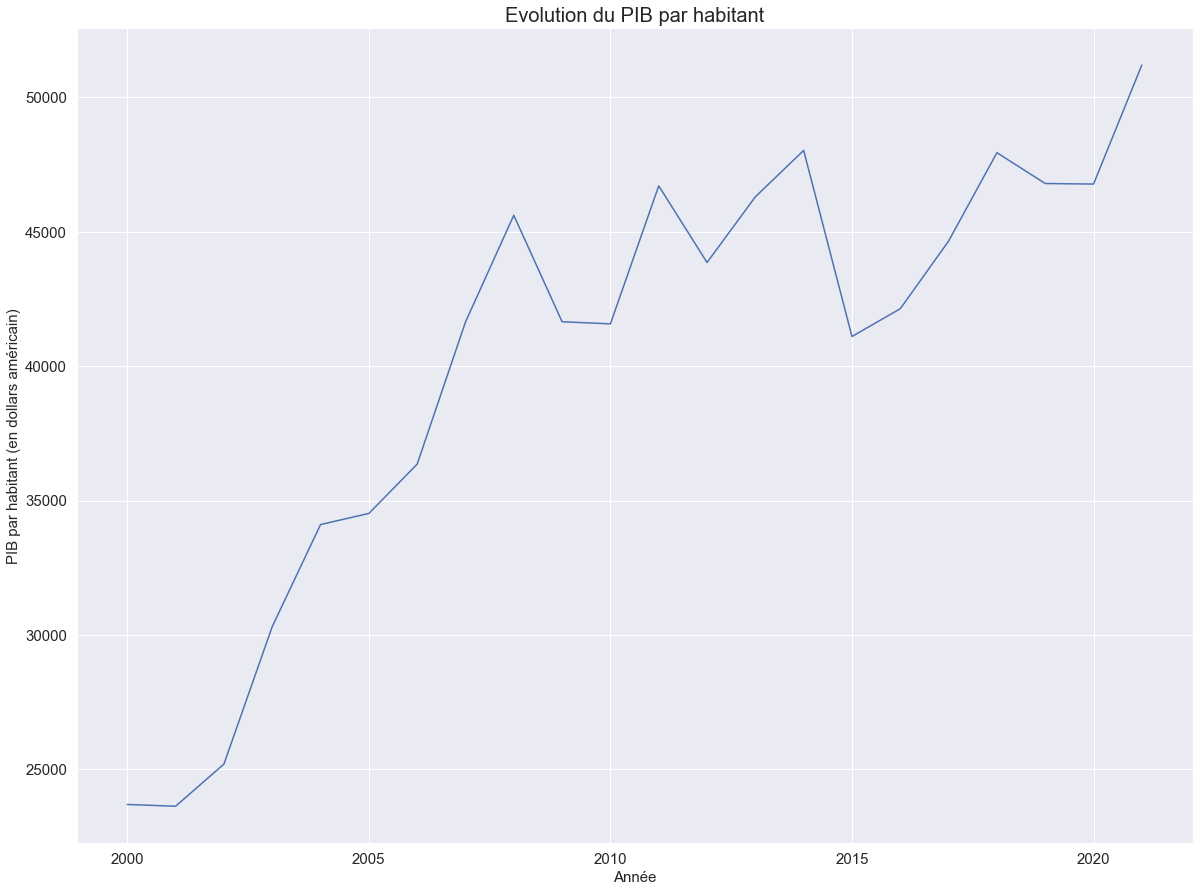

In [67]:
sns.lineplot(data = PIB[PIB['Country']=='Germany'], x = 'Year', y = 'PIB')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Évolution du PIB par habitant", fontsize = 20)
plt.xlabel("Année",fontsize = 15)
plt.ylabel("PIB par habitant (en dollars américains)", fontsize = 15)
plt.savefig('evolution_pib_GB.png')
plt.show()

Sur ce graphique, nous constatons que le PIB a dépassé  les 45k dollars américains alors que la France une seule fois et de peu avant de rebaisser.

En 2021, ce PIB est d'environ 51k et il ne baisse pas alors qu'en France il est de 44k.

### Répartition de la production des différents produits alimentaires

In [68]:
dispo_prod = dispo[(dispo['Element']=='Production')&(dispo['Country']=='Germany')]

In [69]:
dispo_cereales = dispo_prod.Quantity[dispo_prod.Item.isin(cereales)].sum()
dispo_edulcorants = dispo_prod.Quantity[dispo_prod.Item.isin(edulcorants)].sum()
dispo_veg = dispo_prod.Quantity[dispo_prod.Item.isin(prod_veg)].sum()
dispo_animaliers = dispo_prod.Quantity[dispo_prod.Item.isin(prod_animaliers)].sum()
dispo_autres = dispo_prod.Quantity[dispo_prod.Item.isin(autres)].sum()

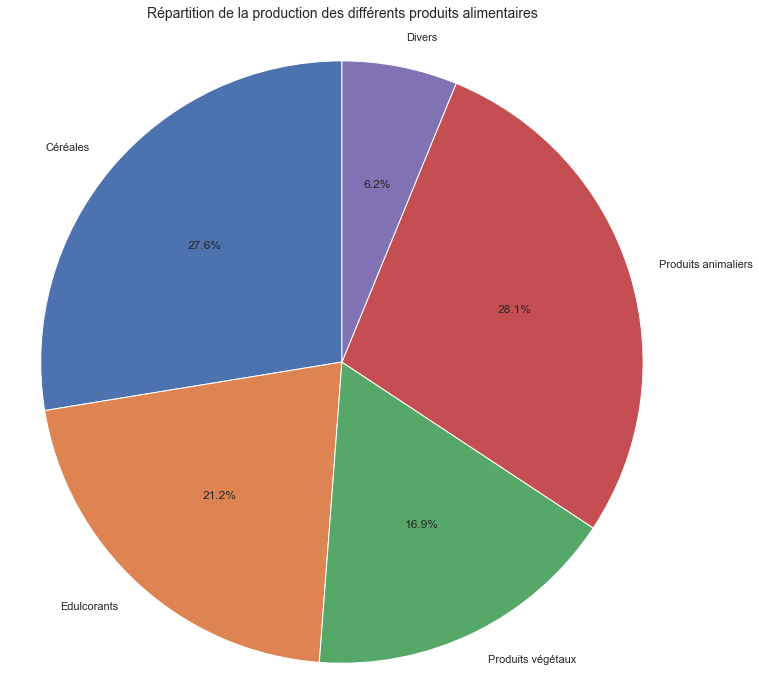

In [70]:
labels = 'Céréales', 'Edulcorants','Produits végétaux','Produits animaliers', 'Divers'
# Etiquettes des différentes parts de notre graphique

sizes = [dispo_cereales, dispo_edulcorants, dispo_veg,dispo_animaliers, dispo_autres]
# Tailles de chaque part de notre graphique

plt.figure(figsize = (12,12))
# Taille du graphique

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
# Création du graphique avec les spécificités prédéfinies

plt.title('Répartition de la production des différents produits alimentaires', fontsize = 14, pad=20)
# Titre du graphique

plt.axis('equal')
# Permet de faire en sort que la forme finale soit bien un cercle

plt.savefig('repartition_prod_A.png')

plt.show()

Dans ce pays, la production est principalement des produits d'origine animale et des céréales, suivi de près des edulcorants et des produits d'origine végétale.

### Répartition des exports des différents produits alimentaires

In [71]:
dispo_exp = dispo[(dispo['Element']=='Export Quantity')&
                  (dispo['Country']=='Germany')]

In [72]:
dispo_cereales = dispo_exp.Quantity[dispo_exp.Item.isin(cereales)].sum()
dispo_edulcorants = dispo_exp.Quantity[dispo_exp.Item.isin(edulcorants)].sum()
dispo_veg = dispo_exp.Quantity[dispo_exp.Item.isin(prod_veg)].sum()
dispo_animaliers = dispo_exp.Quantity[dispo_exp.Item.isin(prod_animaliers)].sum()
dispo_autres = dispo_exp.Quantity[dispo_exp.Item.isin(autres)].sum()

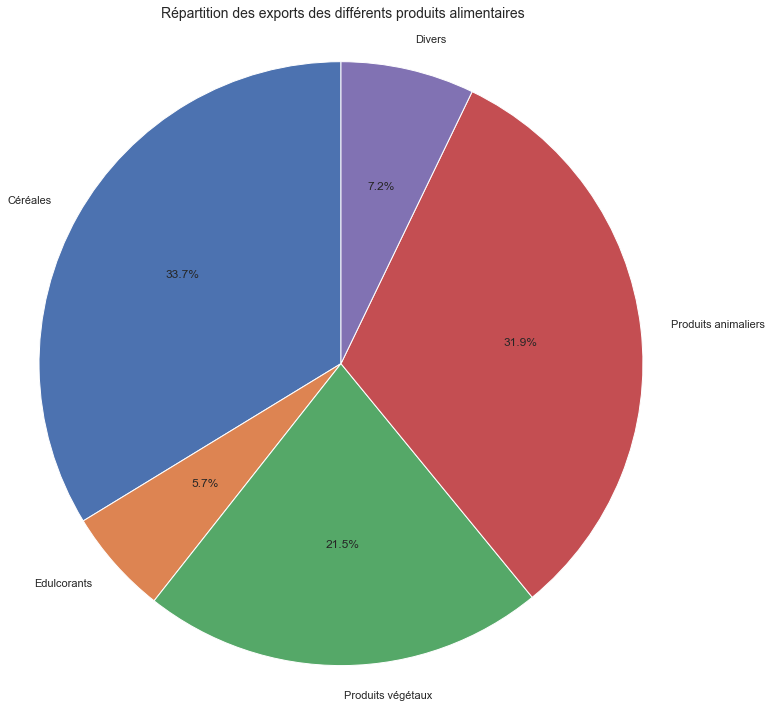

In [73]:
labels = 'Céréales', 'Edulcorants','Produits végétaux','Produits animaliers', 'Divers'
# Etiquettes des différentes parts de notre graphique

sizes = [dispo_cereales, dispo_edulcorants, dispo_veg, dispo_animaliers, dispo_autres]
# Tailles de chaque part de notre graphique

plt.figure(figsize = (12,12))
# Taille du graphique

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
# Création du graphique avec les spécificités prédéfinies

plt.title('Répartition des exports des différents produits alimentaires', fontsize = 14, pad=20)
# Titre du graphique

plt.axis('equal')
# Permet de faire en sort que la forme finale soit bien un cercle

plt.savefig('repartition_export_A.png')

plt.show()

L'Allemagne exporte plus de produits d'origine animal et de céréales que tout autre type de produit. 

Pour rappel, plus de la moitié des exports de la France concerne les céréales.

### Répartition des imports des différents produits alimentaires

In [74]:
dispo_imp = dispo[(dispo['Element']=='Import Quantity')&
                  (dispo['Country']=='Germany')]

In [75]:
dispo_cereales = dispo_imp.Quantity[dispo_imp.Item.isin(cereales)].sum()
dispo_edulcorants = dispo_imp.Quantity[dispo_imp.Item.isin(edulcorants)].sum()
dispo_veg = dispo_imp.Quantity[dispo_imp.Item.isin(prod_veg)].sum()
dispo_animaliers = dispo_imp.Quantity[dispo_imp.Item.isin(prod_animaliers)].sum()
dispo_autres = dispo_imp.Quantity[dispo_imp.Item.isin(autres)].sum()

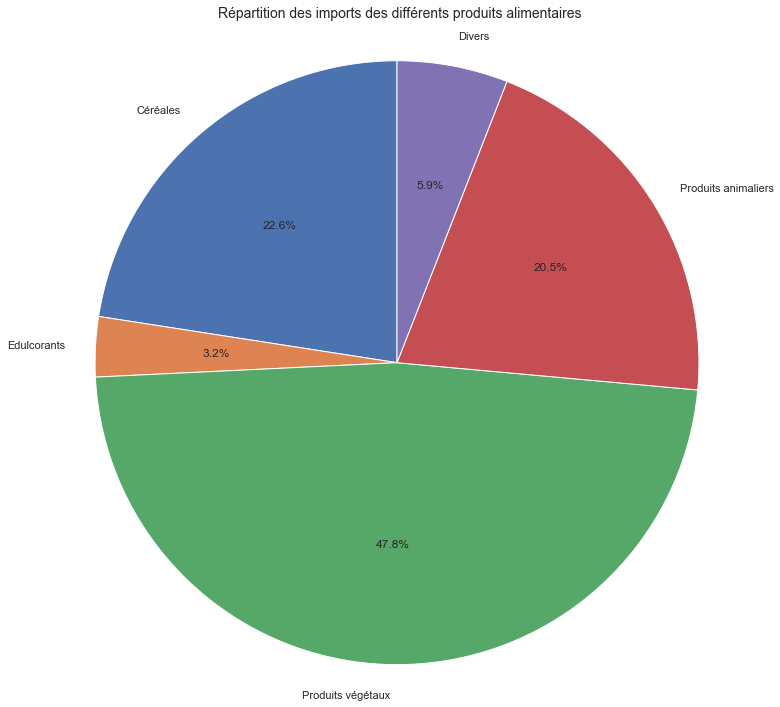

In [76]:
labels = 'Céréales', 'Edulcorants','Produits végétaux','Produits animaliers','Divers'
# Etiquettes des différentes parts de notre graphique

sizes = [dispo_cereales, dispo_edulcorants, dispo_veg, dispo_animaliers, dispo_autres]
# Tailles de chaque part de notre graphique

plt.figure(figsize = (12,12))
# Taille du graphique

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
# Création du graphique avec les spécificités prédéfinies

plt.title('Répartition des imports des différents produits alimentaires', fontsize = 14, pad=20)
# Titre du graphique

plt.axis('equal')
# Permet de faire en sort que la forme finale soit bien un cercle

plt.savefig('repartition_import_A.png')

plt.show()

La moitié des importations du pays sont principalement des produits d'origine végétale, ce qui est pareil en France bien que les proportions diffèrent.

L'Allemagne importe en second de la viande ainsi que des céréales.

### Répartition des différents produits alimentaire dans l'alimentation

In [77]:
dispo_food = dispo[(dispo['Element']=='Food')&(dispo['Country']=='Germany')]

In [78]:
dispo_cereales = dispo_food.Quantity[dispo_food.Item.isin(cereales)].sum()
dispo_edulcorants = dispo_food.Quantity[dispo_food.Item.isin(edulcorants)].sum()
dispo_veg = dispo_food.Quantity[dispo_food.Item.isin(prod_veg)].sum()
dispo_animaliers = dispo_food.Quantity[dispo_food.Item.isin(prod_animaliers)].sum()
dispo_autres = dispo_food.Quantity[dispo_food.Item.isin(autres)].sum()

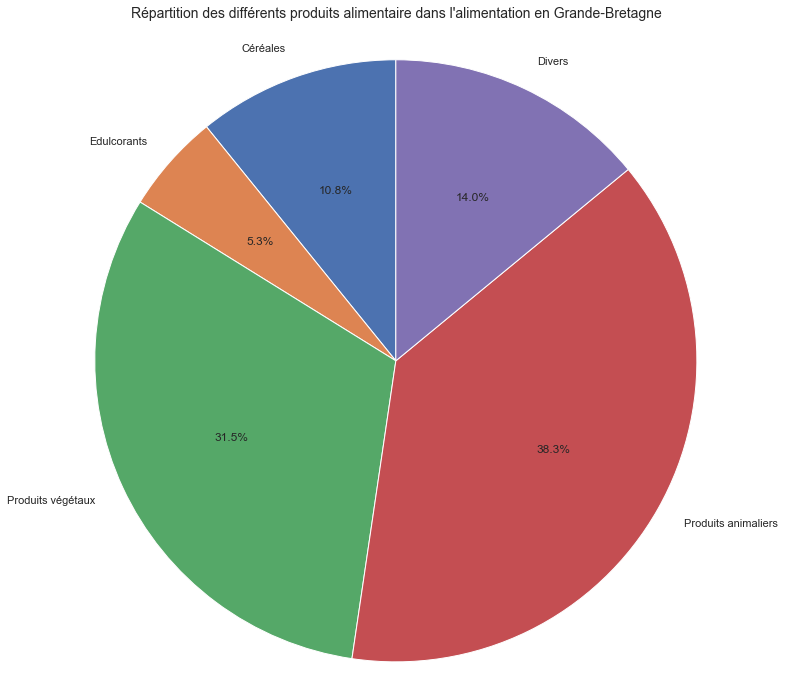

In [79]:
labels = 'Céréales', 'Edulcorants','Produits végétaux','Produits animaliers','Divers'
# Etiquettes des différentes parts de notre graphique

sizes = [dispo_cereales, dispo_edulcorants, dispo_veg, dispo_animaliers, dispo_autres]
# Tailles de chaque part de notre graphique

plt.figure(figsize = (12,12))
# Taille du graphique

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
# Création du graphique avec les spécificités prédéfinies

plt.title('Répartition des différents produits alimentaire dans l\'alimentation en Grande-Bretagne', fontsize = 14, pad=20)
# Titre du graphique

plt.axis('equal')
# Permet de faire en sort que la forme finale soit bien un cercle

plt.savefig('repartition_food_A.png')

plt.show()

Pour ce dernier diagramme, nous pouvons constater qu'il est similaire à celui obtenu pour la France, donc on peut supposer que l'alimentation française et l'alimentation anglaise sont presque identiques.

### Comparaison des quantités de disponibilité alimentaire des deux pays

Pour commencer, nous allons devoir créer une nouvelle colonne qui nous donnera le types des produits.

In [80]:
dispo = dispo.loc[:,['Country','Element','Item','Quantity']]
dispo

,Country,Element,Item,Quantity
0,Afghanistan,Production,Wheat and products,5185.0
1,Afghanistan,Import Quantity,Wheat and products,2741.0
2,Afghanistan,Export Quantity,Wheat and products,0.0
3,Afghanistan,Food,Wheat and products,6258.0
4,Afghanistan,Production,Rice and products,440.0
...,...,...,...,...
54891,Zimbabwe,Export Quantity,Infant food,0.0
54892,Zimbabwe,Food,Infant food,1.0
54893,Zimbabwe,Import Quantity,Miscellaneous,15.0
54894,Zimbabwe,Export Quantity,Miscellaneous,1.0


In [81]:
dispo['Product_type'] = 'none'
dispo.loc[dispo.Item.isin(cereales),'Product_type']= 'Cereals'
dispo.loc[dispo.Item.isin(edulcorants),'Product_type']= 'Sugar'
dispo.loc[dispo.Item.isin(prod_veg),'Product_type']= 'Vegetables'
dispo.loc[dispo.Item.isin(prod_animaliers),'Product_type']= 'Fish and Meat'
dispo.loc[dispo.Item.isin(autres),'Product_type']= 'Others'
dispo

,Country,Element,Item,Quantity,Product_type
0,Afghanistan,Production,Wheat and products,5185.0,Cereals
1,Afghanistan,Import Quantity,Wheat and products,2741.0,Cereals
2,Afghanistan,Export Quantity,Wheat and products,0.0,Cereals
3,Afghanistan,Food,Wheat and products,6258.0,Cereals
4,Afghanistan,Production,Rice and products,440.0,Cereals
...,...,...,...,...,...
54891,Zimbabwe,Export Quantity,Infant food,0.0,Others
54892,Zimbabwe,Food,Infant food,1.0,Others
54893,Zimbabwe,Import Quantity,Miscellaneous,15.0,Others
54894,Zimbabwe,Export Quantity,Miscellaneous,1.0,Others


Une fois cela fait, nous allons pouvoir faire des tables qui regrouperont les données de la France et de l'Allemagne.

In [82]:
dispo = dispo[(dispo['Country']=='France')|(dispo['Country']=='Germany')]
dispo

,Country,Element,Item,Quantity,Product_type
17838,France,Production,Wheat and products,30144.0,Cereals
17839,France,Import Quantity,Wheat and products,2333.0,Cereals
17840,France,Export Quantity,Wheat and products,21223.0,Cereals
17841,France,Food,Wheat and products,7578.0,Cereals
17842,France,Production,Rice and products,76.0,Cereals
...,...,...,...,...,...
19546,Germany,Export Quantity,Infant food,83.0,Others
19547,Germany,Food,Infant food,0.0,Others
19548,Germany,Import Quantity,Miscellaneous,1201.0,Others
19549,Germany,Export Quantity,Miscellaneous,1309.0,Others


In [83]:
dispo_F_GB = dispo.groupby(by=['Country','Element','Product_type']).sum()
dispo_F_GB = dispo_F_GB.reset_index()
dispo_F_GB

,Country,Element,Product_type,Quantity
0,France,Export Quantity,Cereals,34509.00
1,France,Export Quantity,Fish and Meat,8038.56
2,France,Export Quantity,Others,3260.00
3,France,Export Quantity,Sugar,2942.00
4,France,Export Quantity,Vegetables,9668.78
5,France,Food,Cereals,9128.00
6,France,Food,Fish and Meat,22571.79
7,France,Food,Others,5335.00
8,France,Food,Sugar,2363.00
9,France,Food,Vegetables,16867.00


A partir de cette table, nous pouvons sélectionner les données que nous souhaitons pour regarder plus en détail grâce à la commande suivante 

In [84]:
dispo_F_GB[dispo_F_GB['Element']=='Production']

,Country,Element,Product_type,Quantity
15,France,Production,Cereals,56850.00
16,France,Production,Fish and Meat,35460.01
17,France,Production,Others,7780.00
18,France,Production,Sugar,31673.00
19,France,Production,Vegetables,31336.68
35,Germany,Production,Cereals,43609.00
36,Germany,Production,Fish and Meat,44433.41
37,Germany,Production,Others,9790.00
38,Germany,Production,Sugar,33572.00
39,Germany,Production,Vegetables,26736.00


Cette table nous permet de comprendre que l'Allemagne produit autant de produits alimentaires que la France.

La france produit cependant pllus de céréales que l'Allemagne tandis que celle-ci produit plus de viandes et de poissons.

In [85]:
dispo_F_GB[dispo_F_GB['Element']=='Food']

,Country,Element,Product_type,Quantity
5,France,Food,Cereals,9128.00
6,France,Food,Fish and Meat,22571.79
7,France,Food,Others,5335.00
8,France,Food,Sugar,2363.00
9,France,Food,Vegetables,16867.00
25,Germany,Food,Cereals,7788.00
26,Germany,Food,Fish and Meat,27542.33
27,Germany,Food,Others,10095.00
28,Germany,Food,Sugar,3834.00
29,Germany,Food,Vegetables,22666.00


Sa consommation diffère en ce sens que la population consomme quasiment le double de produits 'divers'.

In [86]:
dispo_F_GB[dispo_F_GB['Element']=='Export Quantity']

,Country,Element,Product_type,Quantity
0,France,Export Quantity,Cereals,34509.00
1,France,Export Quantity,Fish and Meat,8038.56
2,France,Export Quantity,Others,3260.00
3,France,Export Quantity,Sugar,2942.00
4,France,Export Quantity,Vegetables,9668.78
20,Germany,Export Quantity,Cereals,17193.00
21,Germany,Export Quantity,Fish and Meat,16280.67
22,Germany,Export Quantity,Others,3646.00
23,Germany,Export Quantity,Sugar,2885.00
24,Germany,Export Quantity,Vegetables,10981.95


L'Allemagne exporte moins ses denrées alimentaires que la France.

Elle exporte deux fois moins de viandes et de céréales.

In [87]:
dispo_F_GB[dispo_F_GB['Element']=='Import Quantity']

,Country,Element,Product_type,Quantity
10,France,Import Quantity,Cereals,4513.00
11,France,Import Quantity,Fish and Meat,6714.38
12,France,Import Quantity,Others,2966.00
13,France,Import Quantity,Sugar,937.00
14,France,Import Quantity,Vegetables,16850.02
30,Germany,Import Quantity,Cereals,14835.00
31,Germany,Import Quantity,Fish and Meat,13490.96
32,Germany,Import Quantity,Others,3902.00
33,Germany,Import Quantity,Sugar,2112.00
34,Germany,Import Quantity,Vegetables,31444.25


Ici, il y a plusieurs points à relever :
 - l'Allemagne importe quasiment quatre fois plus de céréales que la France
 - elle importe deux fois plus de viandes, de fruits et légumes et d'edulcorants que la France

Nous pouvons conclure qu'il serait tout à fait possible d'exporter nos poulets vers ce pays par exemple.

# Conclusion

Pour conclure, nous allons faire un point sur les données utilisées :
 - nous avons pu réunir la plupart des données qu'une analyse PESTEL requiert
 - il est à noter que le site de la FAO ne fournit plus certaines données pour certains pays, par exemple l'index de la stabilité politique de la Chine

En ce qui concerne les résultats des analyses, je recommande l'implantation du nouveau magasin dans un pays du groupe 1 formé par nos analyses avec par exemple l'Allemagne en tête de liste.